In [0]:
%reset

# [ IMPORTS ]

In [0]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.signal as scsig

# [ GLOBAL ]

In [0]:
#===========================================================================================================
# DEFINE SOURCE DIRECTORIES
#===========================================================================================================
# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data' #'/home/spooky/ecg/workdir'
print('GLOBAL DIR :: '+global_dir)

#===========================================================================================================
#  following are required for one time npy database building

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BEAT_POSTFIX = 'BEAT'         #<<--- beat annotations
g_NBEAT_POSTFIX = 'NBEAT'       #<<--- non-beat annotations
g_RAW_II_POSTFIX = 'RAW_II'     #<<--- Raw lead2 signal from mat file
g_BLF_II_POSTFIX = 'BLF_II'     #<<--- Baseline fitted signal
g_RES_II_POSTFIX = 'RES_II'     #<<--- Resampled to BASIC_SRATE
g_SIG_II_POSTFIX = 'SIG_II'     #<<--- Removed manual gain
#===========================================================================================================

#=================================================
# Auto-Create other working directory
#=================================================
# >> model directory, contains model weights, use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

# >> dataset directory, contains manually generated datasets to be used for experiment
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATASET DIR :: ' + global_dsdir)

# >> temp directory, contains manually generated temporary data to be used for experiments
global_tempdir = os.path.join(global_dir, 'db_temp') 
print('GLOBAL TEMP DIR :: ' + global_tempdir)
#>>----------------------------------------------- 

# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 

# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))

GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATASET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL TEMP DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_temp
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant
Basic sampling rate(Hz): 128


# [ EXPERIMENT_SETUP ]

## [ Experiment params ]

In [0]:
#*************************************************
# Define Experiment Secific Param
#*************************************************
exp_name = 'exp_V_clf'
print('Experiment::',exp_name)
#>>---------------------------------------------- 

#=================================================
# Signal Sampling Params
#=================================================
# fixed input dimension for beat vector
v_dimC = int(round((3*BASIC_SRATE))) # 3 seconds
print('Fixed dimension of beat vector: '+str(v_dimC))
#>>-----------------------------------------------


Experiment:: exp_V_clf
Fixed dimension of beat vector: 384


# [ SELECT ANT MAPPER ] 

In [0]:
ls_ants = os.listdir(global_antdir)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

Available annotation files [2]
ant_V_clf.txt
annotations_basic.txt
--------------------------


## [ *mapping_file* ]

In [0]:
#=================================================
# Read annotation mapping from file
#=================================================
ant_file = 'ant_V_clf' + '.txt'

exp_annot = os.path.join(global_antdir, ant_file) 
print('ANNOTATIONS FILE :: '+ exp_annot)
g_map_data = np.loadtxt(exp_annot, dtype='str',delimiter="\t")
g_map={}
print('ANNOTATION MAPPING :: ')
for a in g_map_data:
    g_mit_label = a[0] # orignal mit label (char)
    g_int_label = a[1] # mapped integer label (int)
    g_beat_description = a[2] # description (str)
    g_map[g_mit_label]= int(g_int_label) ##<<----------------mapping dictionary
    print(g_mit_label+'\t'+g_int_label+'\t'+g_beat_description)
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_map[peak_label[i]]
    return res
print('')
print('All Annotations : [' + str(len(g_map))+'] :: ' + str(g_map.keys()))
print('')

#>>-----------------------------------------------


ANNOTATIONS FILE :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant/ant_V_clf.txt
ANNOTATION MAPPING :: 
N	0	Normal beat
L	-1	Left bundle branch block beat
R	-1	Right bundle branch block beat
B	-1	Bundle branch block beat (unspecified)
A	-1	Atrial premature beat
a	-1	Aberrated atrial premature beat
J	-1	Nodal (junctional) premature beat
S	-1	Supraventricular premature or ectopic beat (atrial or nodal)
V	1	Premature ventricular contraction
r	-1	R-on-T premature ventricular contraction
F	-1	Fusion of ventricular and normal beat
e	-1	Atrial escape beat
j	-1	Nodal (junctional) escape beat
n	-1	Supraventricular escape beat (atrial or nodal)
E	-1	Ventricular escape beat
/	-1	Paced beat
f	-1	Fusion of paced and normal beat
Q	-1	Unclassifiable 
?	-1	Beat not classified during learning
[	-2	Start of ventricular flutter/fibrillation
!	-2	Ventricular flutter wave
]	-2	End of ventricular flutter/fibrillation
x	-2	Non-conducted P-wave (blocked APC)
(	-2	Waveform onset
)	-2	Waveform end
p	-2

## [ *mapping_labels* ]

In [0]:
#=================================================
# Define Custom Class Labels, as per mapped indices
#=================================================
g_LABELS_MAP = np.array([
            ['N','tab:green'],      # Normal
            ['V','tab:blue'],      # VEB
            ])  #<<--- integer label have one to one correspondence with incides in g_LABELS

g_LABELS = g_LABELS_MAP[:,0]
g_COLOR = g_LABELS_MAP[:,1]
# T10 categorical palette
# ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
# 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
# 'tab:olive', 'tab:cyan']
print('CLASS LABELS : ', g_LABELS)
#>>-----------------------------------------------

CLASS LABELS :  ['N' 'V']


# [ CLASS_DEFS ]

In [0]:
#Class Definitions
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  exclude_recs, tag_recs, sampling_rate):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #float or int
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_recs)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'SAMPLING RATE :: '+ str(self.srate))
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if recname in db.recs_all:
            if recname in db.recs_exc:
                print('WARNING:: Record "'+ recname +'" is marked excluded from database '+ db.name )
        else:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

class ecg_binfo:
    def __init__(self, rec):
        self.rec = rec          # the record object
        rr_peaks_ants = rec.read_data(g_BEAT_POSTFIX)       # orignal ant file [ *  '625310' 'N' * ]
        # slice array
        rr_peaks_int = rr_peaks_ants[:,0].astype('int')     # col0 : samples * 62531 *  <---------------- not excluded
        rr_ants_str = rr_peaks_ants[:,1]                    # col1 : labels * 'N' *     <---------------- not excluded
        
        # excluded first and last
        self.rr_peaks = rr_peaks_int[1:-1]                  # col0 : samples (int) 62531 ==>==>==> sample# (orignal)
        self.rr_prev = rr_peaks_int[0:-2]                   # prev R peak (in samples)
        self.rr_next = rr_peaks_int[2:]                                           # next R peak (in samples)
        self.nos_rr_peaks = len(self.rr_peaks)              # no fo RR peaks (excluding first and last)
        
        self.rr_labels = rr_ants_str[1:-1]                  # col1 : labels (str)  'N'  ==>==>==> mit label (orignal)
        self.rr_plabels = rr_ants_str[0:-2]                  # col1 : labels (str)  'N'  ==>==>==> mit label (orignal)
        self.rr_nlabels = rr_ants_str[2:]                  # col1 : labels (str)  'N'  ==>==>==> mit label (orignal)

        rr_ants_int = mapstd(rr_ants_str)
        self.rr_int_labels = rr_ants_int[1:-1]         # col1 : mapped int labels ==>==>==> int label (mapped -1, 0 ...) cant be -2 in 
        self.rr_int_plabels = rr_ants_int[0:-2]   
        self.rr_int_nlabels = rr_ants_int[2:]   

        #temporal info
        self.rr_peaks_sec = self.rr_peaks / rec.db.srate             # col0 : time in sec (float) ==>==>==> sample (time in sec) sample#/srate
        self.rri_prev = (self.rr_peaks - self.rr_prev) / rec.db.srate   # prev RRI (in sec) 
        self.rri_next = (self.rr_next - self.rr_peaks) / rec.db.srate  # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)        # difference b/w prev and next RRI in seconds 
        self.rri_dur = (self.rri_next + self.rri_prev)
        self.sr_ratio = BASIC_SRATE/self.rec.db.srate

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
    # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        ff = int(self.rr_prev[ith_peak]*self.sr_ratio)
        tt = int(self.rr_next[ith_peak]*self.sr_ratio)
        pp = int(self.rr_peaks[ith_peak]*self.sr_ratio)
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG_II_POSTFIX) 
        #sr_ratio = BASIC_SRATE/self.rec.db.srate
        ff = int((self.rr_peaks[ith_peak]*self.sr_ratio)-(v_left_sec*BASIC_SRATE))
        tt = int((self.rr_peaks[ith_peak]*self.sr_ratio)+(v_right_sec*BASIC_SRATE))
        pp = int(self.rr_peaks[ith_peak]*self.sr_ratio)
        return sel_sig[ff:tt+1], (pp-ff) #<- also return position of peak
    
#-----------------------------------------------------------------------------------------------


# [ BUILD_ALL_DB ]

In [0]:
print('Buidling all_db')
all_db = {}
#------------------------------------------------------------------------
mitdb_ex = []
mitdb_tags = []
all_db['mitdb'] = ecg_db('mitdb',  mitdb_ex, mitdb_tags, 360)
#------------------------------------------------------------------------
svdb_ex = []
svdb_tags = []
all_db['svdb'] = ecg_db('svdb',  svdb_ex, svdb_tags, 128)
#------------------------------------------------------------------------
incartdb_ex = []
incartdb_tags = []
all_db['incartdb'] = ecg_db('incartdb', incartdb_ex, incartdb_tags, 257)
#------------------------------------------------------------------------
print('')
print(all_db.keys())


# [ 5_PREPARE_WORKING_DBs ]

In [0]:
#-----------------------------------------------------------------------------------------
mitdb_ex = ['102', '104', '107', '217', ##<<- Paced reacord
            '212', '231',  '207',       ##<<- both L and R BBB
            '223',                      ##<<- only record with 16 'e' type beats
            '222','124', '201',         ##<<- removes most of 'j' type beats from mitdb
            '232',                      ##<<- poor representative normal
            '214', '118', '111', '109',         ##<<- removes all L and R type beats
            ]

svdb_ex = [
        
            ] #<-- les than 10 nrep normals

incartdb_ex = [
               'I09', 'I10', 'I11',         # patient 5 only patient in cartdb with 32 'n' type beats
               'I59', 'I60', 'I61',         # patient 26 - removes most of 'j' type beats from incartdb
               'I16', 'I17',                # patient 8 Transient ischemic attack - removes L and R type
                'I70', 'I71'                # patient 30 - both R and N

                ]

#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#<<--------------------- FOR TRAINING model_01
train_db1 = {} 
train_db1['mitdb'] = ecg_db('mitdb',  mitdb_ex, [], 360)
train_db1['svdb'] = ecg_db('svdb',  svdb_ex, [], 128)
#train_db1['incartdb'] = ecg_db('incartdb', incartdb_ex, [], 257)
#------------------------------------------------------------------------
print('')
print(train_db1.keys())


#-----------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------
#<<--------------------- FOR TESTING model_01
test_db1 = {} 
#test_db1['mitdb'] = ecg_db('mitdb',  mitdb_ex, [], 360)
#test_db1['svdb'] = ecg_db('svdb',  svdb_ex, [], 128)
test_db1['incartdb'] = ecg_db('incartdb', incartdb_ex, [], 257)
#------------------------------------------------------------------------
print('')
print(test_db1.keys())



Initailze new ecg database ... 
DB NAME :: mitdb
SAMPLING RATE :: 360
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORD SET :: [32] {'116', '205', '215', '103', '203', '122', '209', '220', '221', '113', '202', '123', '119', '100', '234', '228', '233', '210', '208', '219', '108', '200', '213', '230', '112', '101', '105', '114', '121', '115', '117', '106'}

Initailze new ecg database ... 
DB NAME :: svdb
SAMPLING RATE :: 128
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORD SET :: [78] {'862', '875', '885', '846', '876', '877', '805', '873', '801', '853', '820', '847', '858', '882', '803', '886', '809', '845', '829', '859', '855', '844', '870', '850', '880', '893', '861', '804', '848', '865', '843', '856', '841', '888', '802', '849', '828', '812', '823', '821', '867', '887', '892', '852', '869', '811', '808', '810', '874', '864', '879', '822', '840', '863', '889', '884', '842', '854', '894', '872', '866', '890', '891',

# [ REP_NORMALS_TRAINING ]

In [0]:
#------------------------------------------------------------------------
lim_first_F_sec = 30*60 # 30 minutes for training #<<====select this
#------------------------------------------------------------------------
work_db = train_db1 #<<------------ select working db

g_REP_II_POSTFIX = 'REP_'+str(lim_first_F_sec)+'_'+exp_name # representative normal all record
lim_delta_rri = 0.04
lim_min_Nbeats = 10
#------------------------------------------------------------------------

print('=================================================')
print('Representative Normal')
print('lim_delta_rri:'+str(lim_delta_rri))
print('lim_min_Nbeats_per_episode:'+str(lim_min_Nbeats))
print('lim_first_F_sec:'+str(lim_first_F_sec))
print('g_REP_II_POSTFIX:'+str(g_REP_II_POSTFIX))
print('=================================================')

timestamp_start = datetime.datetime.now()
print('DB_RECORD\t#query\t#epi\tResult')

for idb in work_db.keys():
    sel_db = work_db[idb]
    #if idb != 'mitdb':
    #    continue
    for irec in sel_db.recs:      
       # if irec != '208':
      #      continue
        sel_rec = sel_db.get_record(irec)
        rst = sel_rec.name

#--------# load signal----------------------------------------
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            continue
        
#--------# load beat info----------------------------------------
        sbi = sel_rec.read_binfo()

#-------# Normal Episodes----------------------------------------
        ne_list = []
        ne_query = (
                    (sbi.rr_peaks_sec <= lim_first_F_sec) &
                    (np.absolute(sbi.rri_delta)<=lim_delta_rri) & 
                    (sbi.rr_int_labels==0)  &
                    (sbi.rr_int_plabels==0)  &
                    (sbi.rr_int_nlabels==0)
                  )
        
        ne_list = np.where(ne_query)[0]
        
        if len(ne_list)<lim_min_Nbeats:
            rst+='\tNot enough N beats within rri limits, Skip this record'
            print(rst )
            continue
        else:
            rst+='\t'+str(len(ne_list))   
            
        ne_list1 = np.hstack((np.sort(ne_list),np.array([-1])))
        n_epi = []
        # extract episodes from ne_list
        n_s = ne_list[0]
        delta = 1
        for i in range(1, len(ne_list1)):
            n_e = ne_list1[i]
            if n_e == n_s + delta:
                delta+=1
            else:
                # check if enough number of N beats exist
                if delta >=lim_min_Nbeats:
                    n_epi.append([n_s,n_s+delta])
                n_s = n_e
                delta = 1

        rst+='\t'+ str(len(n_epi))
        if len(n_epi)==0:
            rst+='\tFailed'
            print(rst)
            continue    
        # select from all episodes
        # [epi_index,nos_beats, avg_dur,var_dur,max_dur(signal_len) ]
        
        mega_epi = np.zeros((0,2*v_dimC + 4),dtype='float')
        # 2*vdim for resampled median and mean, 
        # +4 for avg_dur, var_dur, nos_beats, actual signal_len
        
        epi_stats = np.zeros((0,4),dtype='float')
        #epi_short = 0
        for j in range(0, len(n_epi)):
            sepi = n_epi[j]
            bepi = sepi[1]-sepi[0]
            sdur =  sbi.rri_dur[sepi[0]:sepi[1]]
            sdur_avg = round(stats.mean(sdur),3)
            sdur_var = round(stats.variance(sdur),5)
            epi_stats = np.vstack((epi_stats,np.array([j,bepi,sdur_avg,sdur_var])))
            # print('Avg_duration = '+ str(sdur_avg)+ ' | bpm = '+ str(60/sdur_avg))
            # print('VAr_duration = '+ str(sdur_var))
            # print('#'+str(j)+'\t'+str(bepi)+'\t'+str(sdur_avg)+'\t'+str(sdur_var))
            
            #now for each episode find            
            all_epi_signals = []
            all_epi_pk = []
            sg_left=[]
            sg_right=[]
            sll,slr = [],[]
            
            for i in range(sepi[0],sepi[1]):
                sg,pk = sbi.get_signal_data_var(i)
                all_epi_signals.append(sg)
                all_epi_pk.append(pk)
                sg_left.append(sg[0:pk])
                sg_right.append(sg[pk:])
                sll.append(pk)
                slr.append(len(sg)-pk)
            
            ll_max = max(sll)
            lr_max = max(slr)
            l_max = ll_max+lr_max                
            
            sg_all2 =  np.zeros((0,l_max))
            for i in range(0, bepi):    
                sg_all2 = np.vstack((
                                sg_all2,
                                np.hstack((
                                    scsig.resample(sg_left[i],ll_max), 
                                    scsig.resample(sg_right[i],lr_max)
                                    ))
                                ))
            
            x3_men = np.zeros(l_max)
            x3_med = np.zeros(l_max)
            #x3_var = np.zeros(l_max)
            for i in range(0, l_max):
                x3_men[i] = stats.mean(sg_all2[:,i])
                x3_med[i] = stats.median(sg_all2[:,i])
                #x3_var[i] = stats.variance(sg_all2[:,i])     
            
            # [nos_beats,signal_len, avgd,vard, mean,median] signal_len/Basic_srate = duration
            rec_epi = np.array([ bepi,l_max,sdur_avg,sdur_var ])
            rec_epi = np.hstack((rec_epi,
                                    scsig.resample(x3_men,v_dimC),
                                    scsig.resample(x3_med,v_dimC) ))
            mega_epi = np.vstack((mega_epi, rec_epi ))
            
        #rst+= '\t'+ str(len(mega_epi))
        if len(mega_epi) > 0:      
            sel_rec.save_data_temp(g_REP_II_POSTFIX, mega_epi, global_tempdir)
            rst+= '\tSuccess'
        else:
            rst+= '\tFailed [cont]'
        print(rst)


print('\nDone')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
#------------------------------------------------------------------------


Representative Normal
lim_delta_rri:0.04
lim_min_Nbeats_per_episode:10
lim_first_F_sec:1800
g_REP_II_POSTFIX:REP_1800_exp_V_clf
DB_RECORD	#query	#epi	Result
mitdb_116	2056	62	Success
mitdb_205	2478	27	Success
mitdb_215	2669	104	Success
mitdb_103	1639	21	Success
mitdb_203	335	0	Failed
mitdb_122	2388	49	Success
mitdb_209	2049	66	Success
mitdb_220	1669	56	Success
mitdb_221	321	0	Failed
mitdb_113	645	1	Success
mitdb_202	913	6	Success
mitdb_123	462	0	Failed
mitdb_119	597	8	Success
mitdb_100	1873	71	Success
mitdb_234	2665	17	Success
mitdb_228	548	0	Failed
mitdb_233	886	10	Success
mitdb_210	642	0	Failed
mitdb_208	220	2	Success
mitdb_219	411	0	Failed
mitdb_108	828	3	Success
mitdb_200	450	1	Success
mitdb_213	1834	40	Success
mitdb_230	1951	61	Success
mitdb_112	2492	27	Success
mitdb_101	1298	11	Success
mitdb_105	2313	78	Success
mitdb_114	1077	2	Success
mitdb_121	1773	39	Success
mitdb_115	858	4	Success
mitdb_117	1105	22	Success
mitdb_106	539	4	Success
svdb_862	1901	48	Success
svdb_875	1757	33	Succ

# [ Plot_Rep_Normal_Set ]

In [0]:
# select a database and a record within it
work_db = train_db1
#-----------------------------------------
idb = 'mitdb'
irec = '200'
#-----------------------------------------
sel_db = work_db[idb]
sel_rec = sel_db.get_record(irec)
print(sel_rec.name)
#-----------------------------------------

mitdb_200


## [ Get REP NORM Set ]

mitdb_200	(1, 772)
Total reps = 1
#epi	#beats	sig_len	avg_dur	var_dur	max_dur
0	11.0	168.0	1.238	0.002	1.312


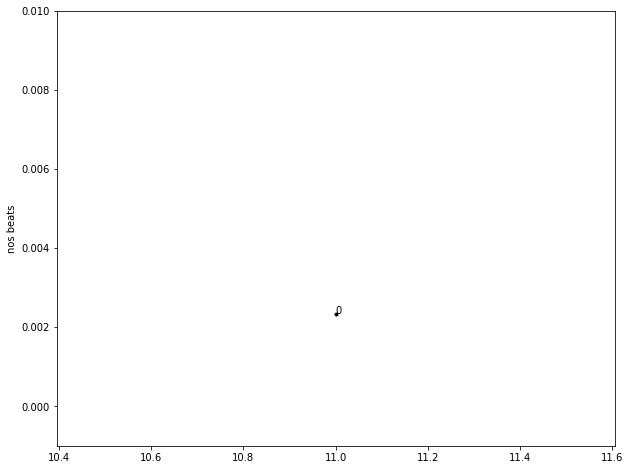

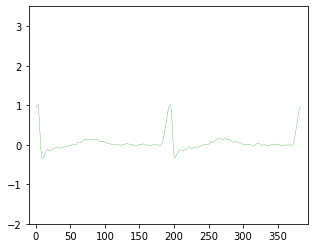

In [0]:
# plot representative set

#<<---------------------------------------------Select rep_norm set to be plotted
g_REP_II_POSTFIX = 'REP_1800_exp_V_clf'
#g_REP_II_POSTFIX = 'REP_300'


jx = sel_rec.load_data_temp(g_REP_II_POSTFIX,global_tempdir)
print (sel_rec.name+'\t'+str(jx.shape))
print ('Total reps = '+ str(len(jx)))

plt.figure(0,figsize=(10,8))
plt.ylabel('duration variance')
plt.xlabel('nos beats')
plt.ylim(-0.001, 0.01)
plt.xlim(0,max(jx[:,0])+1)
plt.scatter(jx[:,0], jx[:,3],marker='.', color='black')
for i in range(0,len(jx)):
    plt.annotate(str(i),xy=(jx[i,0], jx[i,3]))

#[nos_beats,signal_len, avgd,vard, mean,median] signal_len/Basic_srate = duration
print('#epi\t#beats\tsig_len\tavg_dur\tvar_dur\tmax_dur')
plt.figure(1,figsize=(5,4))
plt.ylim(-2,3.5)
plt.xlim(-10,v_dimC+10)
for cepi in range(0,len(jx)):
    iepi = jx[cepi]
    n0 = round(iepi[0])
    n1 = round(iepi[1])
    n2 = round(iepi[2],3)
    n3 = round(iepi[3],3)
    n4 = round(n1/(128),3)
    print(str(cepi)+'\t'+str(n0)+'\t'+str(n1)+'\t'+str(n2)+'\t'+str(n3)+'\t'+str(n4))
    n_med = iepi[-v_dimC:]
    n_men = iepi[4:4+v_dimC]
    #<<---------------------------------------------Select Rep_N Median or Mean Beat to be plotted
    plt.plot(n_med, linewidth=0.3, color='tab:green') 
    #plt.plot(n_men, linewidth=0.3, color='tab:blue')


## [ Plot_Single_Rep_Normal ]

mitdb_215	episode#68
#beats = 10.0
sig_len = 151.0
avg_dur = 1.086
var_dur = 0.003
max_dur = 1.18


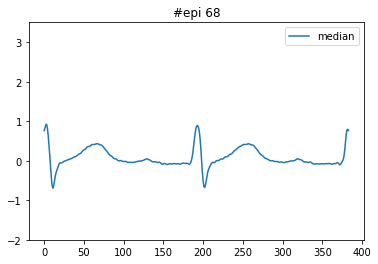

In [0]:
#<<---------------------------------------------Select index from Rep_Normal Set 
sel_episode = 68

print (sel_rec.name+'\tepisode#'+str(sel_episode))
iepi = jx[sel_episode]
jx_men = iepi[4:4+v_dimC]
jx_med = iepi[-v_dimC:]

n0 = round(iepi[0])
n1 = round(iepi[1])
n2 = round(iepi[2],3)
n3 = round(iepi[3],3)
n4 = round(n1/(128),3)
print('#beats = '+str(n0)+'\nsig_len = '+str(n1)+'\navg_dur = '+str(n2)+'\nvar_dur = '+str(n3)+'\nmax_dur = '+str(n4))

plt.figure(sel_episode+2)
plt.ylim(-2,3.5)
plt.title('#epi '+str(sel_episode))
#plt.plot(jx_men,label='mean')
plt.plot(jx_med,label='median')
plt.legend()


# [ 6_GENRATE_DATASETS ]

In [0]:
# CELL 0
'''
1. Select train_db dict object [CELL 1]
2. Select g_CLASS_II_POSTFIX and limit values [CELL 2]
3. Select your query [CELL 3]
'''
#%% CELL 1
#------------------------------------------------------------------------
train_db = train_db1

#%% CELL 2
#------------------------------------------------------------------------
g_CLASS_II_POSTFIX = 'CLASS'   ##<<<<---------------- [select your post fix]
lim_lower, lim_upper = 40, 100 ##<<<<---------------- [select your beat limits]

# log file --------------------------------------------------------------------
log_file= os.path.join(global_datadir, g_CLASS_II_POSTFIX+'_db_build_log.txt') 
def print_log(log_string):
    log_handle.write(log_string+'\n')

#%% CELL 3
#------------------------------------------------------------------------

all_total_sveb = 0
log_handle = open(log_file,'w')
timestamp_start = datetime.datetime.now()
print('\n Start Iteration for '+g_CLASS_II_POSTFIX+' \n')
print_log(g_CLASS_II_POSTFIX+'_LOG_START ['+str(timestamp_start)+ ']')
print_log('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
    #    continue
    for irec in sel_db.recs:
    #    if irec!='865':
    #        continue
        rst = ''
        sel_rec = sel_db.get_record(irec)      
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst += str(sel_rec.name)+'\t'
        
        #============================================================
        print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            
            #============================================================
            print_log(' >>Signal doesnt exist, Skip this record')
            #============================================================
                    
            continue
        
        sbi = sel_rec.read_binfo()      # load beat info
    

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        sveb_list = []
        sveb_query = () ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        sveb_list = np.where(sveb_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    
    
        
        if len(sveb_list)<lim_lower:
            rst+='\tNot enough CLASS beats, Skip this record'
            print(rst )
            #============================================================
            print_log(' >>Invalid query_count = '+str(len(sveb_list))+ ' - skip record')
            #============================================================
            continue
        else:
            
            #============================================================
            print_log(' >>Valid query_count = '+str(len(sveb_list)))
            #============================================================
            
            
            rst+='\tquery:'+str(len(sveb_list))
            sveb_sel = np.zeros((0,v_dimC+2),dtype='float') # +2 for peak location and duration
            
            if len(sveb_list)<=lim_upper: 
                #============================================================
                print_log('CASE_1::query_count <= upper_limit : Need to select all class beats, iterate ...')
                #============================================================
                rst+='\tquery<=upperlimit'
                # is within selction limits, select all class beats
                for ibeat in sveb_list:
                    sg,pk = sbi.get_signal_data_var(ibeat)
                    
                    #============================================================
                    print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                    #============================================================
                    
                    sg_resamp = scsig.resample(sg,v_dimC)
                    pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                    beat_duration = sbi.rri_dur[ibeat]
                    
                    #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                    a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                    
                    #============================================================
                    #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                    #============================================================
                    
                    sveb_sel = np.vstack((sveb_sel, a_resamp)) # done now save it
                    
                #============================================================
                print_log('CASE_1::End of Selection, beats_selected = '+ str(sveb_sel.shape))
                #============================================================
                   
            else: # len(sveb_list)>lim_upper
                # more than upper_limit find episodes
                
                #============================================================
                print_log('CASE_2::query_count > upper_limit : Do not select all class beats. Find episodes...')
                #============================================================
                
                rst+='\tquery>upperlimit'
                sveb_list1 = np.hstack((np.sort(sveb_list),np.array([-1])))
                
                sveb_epi = []
                # extract episodes from sveb_list
                s_s = sveb_list[0]
                delta = 1
                for i in range(1, len(sveb_list1)):
                    s_e = sveb_list1[i]
                    if s_e == s_s + delta:
                        delta+=1
                    else:
                        sveb_epi.append([s_s,s_s+delta])
                        s_s = s_e
                        delta = 1      
                        
                if len(sveb_epi)==0:
                    rst+='\tImpossible::Not enough class episodes, Skip this record'#<<- this cannot happen
                    print(rst)
                    print_log('CASE_2::Impossible, no class episodes exist!!')
                    continue    
                else:
                    rst+='\t'+ str(len(sveb_epi))    
                #============================================================
                print_log(' >>found episodes : '+ str(len(sveb_epi))+'\n >>compare #episodes and upper selection limit..')
                #============================================================               
  
                if len(sveb_epi)<=lim_upper:
                    delta_ratio = lim_upper/len(sveb_list)
                    
                    #============================================================
                    print_log('CASE_2.1::Less episodes than upper limit : Selection ratio [upper_limit/total_beats] = '+str(round(delta_ratio,2)))
                    #============================================================                      
                    
                    rst+='\t#epi<=upperlimit, delta_ratio='+ str(round(delta_ratio,2))
                    # take delta_ratio times beats from each episode
                    
                    #============================================================ 
                    print_log(' >>Prepare rsel: take delta_ratio times beats from each episode, iterate...')
                    #============================================================ 
                    
                    for iepi in range(0,len(sveb_epi)):
                        i_episode = sveb_epi[iepi]

                        beats_in_epi = i_episode[1]-i_episode[0]

                        beats_taken = int(int(beats_in_epi*delta_ratio))
                        if beats_taken==0:
                            beats_taken = 1 # atleast take one beat from each episode
                        
                        #============================================================ 
                        print_log('\tepisode# '+ str(iepi)+'='+str(i_episode)+
                              ' has '+ str(beats_in_epi)+ ' beats, randomly take '+
                              str(beats_taken)+ ' beats')                        
                        #============================================================ 

                        a = np.arange(i_episode[0],i_episode[1])
                        rsel = np.random.choice(a, size=beats_taken, replace=False, p=None)
                        
                        print_log('\t >>Selected: '+ str(rsel)+' iterate...')
                        for ibeat in rsel:
                            sg,pk = sbi.get_signal_data_var(ibeat)
                            
                            #============================================================
                            print_log('\t\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                            #============================================================
                            
                            sg_resamp = scsig.resample(sg,v_dimC)
                            pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                            beat_duration = sbi.rri_dur[ibeat]
                            
                            #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                            a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                            
                            #============================================================ 
                            #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                            #============================================================ 
                            
                            sveb_sel = np.vstack((sveb_sel, a_resamp))  # done now save it
                            
                        #============================================================
                        #print_log('\tend of episode iteration sbeats_selected(this episode) = '+ str(sveb_sel.shape))
                        #============================================================
                        
                    #============================================================
                    print_log('end of all episode iteration beats_selected(overall) = '+ str(sveb_sel.shape))
                    #============================================================
                    
                else: # is in b/w upper and lower limit, select one from each episode

                    delta_epi = int(len(sveb_epi) / lim_upper) #how many extra episodes
                    
                    #============================================================
                    print_log('CASE_2.2::More episodes than upper limit, index step = int[total_episodes / upperlimit] = '+str(round(delta_epi,2)))
                    #============================================================  

                    rst+='\t#epi>upperlimit delta_epi='+ str(round(delta_epi,2))
                    ist = 0
                    rsel=np.zeros(lim_upper,dtype='int')
                    
                    ##============================================================  
                    print_log(' >>Prepare rsel: step indices, select ONE beat randomly from each episode, iterate...')
                    #============================================================  
                    
                    for ix in range(0,lim_upper):
                        i_episode = sveb_epi[ist]
                        beats_in_epi = i_episode[1]-i_episode[0]
                        j_sel = i_episode[0]
                        
                        if beats_in_epi > 1:
                            j_sel = random.randint(i_episode[0],i_episode[1]-1)
                            
                        #============================================================  
                        print_log('\tepisode# '+ str(ist)+'='+str(i_episode)+
                              ' has '+ str(beats_in_epi)+ ' beats, take random # '+
                              str(j_sel))                            
                        #============================================================  
                        
                        rsel[ix] = j_sel
                        ist+=delta_epi
                        
                    #============================================================  
                    print_log('Selected Striding: '+ str(rsel)+' iterate...')
                    #============================================================  
                    
                    for ibeat in rsel:
                        sg,pk = sbi.get_signal_data_var(ibeat)
                        
                        #============================================================
                        print_log('\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                        #============================================================
                        
                        sg_resamp = scsig.resample(sg,v_dimC)
                        pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                        beat_duration = sbi.rri_dur[ibeat]
                        
                        #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                        a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                        
                        #============================================================  
                        #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                        #============================================================  
                        
                        sveb_sel = np.vstack((sveb_sel, a_resamp))    
                        
                    #============================================================
                    print_log('end of iteration beats_selected = '+ str(sveb_sel.shape))
                    #============================================================
                    
            #============================================================
            print_log('end of record, total_beats_selected = '+ str(sveb_sel.shape))
            #============================================================
            
            rst+='\ttotal_CLASS_BEATS:'+ str(len(sveb_sel))
            print(rst)   
            
            sel_rec.save_data_temp(g_CLASS_II_POSTFIX,sveb_sel)
            
            all_total_sveb+=len(sveb_sel)            
            
    # loop end record ----------------------------------------------------------------------------------
# loop end database ----------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
print('\nEnd of Procedure, grand_total_class_beats = '+ str(all_total_sveb))
print_log('\nEnd of Procedure, grand_total_beats = '+ str(all_total_sveb))
print_log('\n'+g_CLASS_II_POSTFIX+'_LOG_END, elapsed time = ['+str(timestamp_dur)+ ']')
log_handle.close()


## [ 6.1_S_CLASS_DS ]

In [0]:
# CELL 0
'''
1. Build train_db dict object [CELL 1]
2. Select g_CLASS_II_POSTFIX and limit values [CELL 2]
3. Select your query [CELL 3, line 65]
'''
#%% CELL 1
#------------------------------------------------------------------------

train_db = train_db1

#%% CELL 2
#------------------------------------------------------------------------

g_CLASS_II_POSTFIX = 'S'   ##<<<<---------------- [select your post fix]
lim_lower, lim_upper = 80, 100 ##<<<<---------------- [select your beat limits]

# log file --------------------------------------------------------------------
#log_file= os.path.join(global_datadir, g_CLASS_II_POSTFIX+'_db_build_log.txt') 
#def print_log(log_string):
#    log_handle.write(log_string+'\n')

#%% CELL 3
#------------------------------------------------------------------------

all_total_sveb = 0
#log_handle = open(log_file,'w')
timestamp_start = datetime.datetime.now()
print('\n Start Iteration for '+g_CLASS_II_POSTFIX+' \n')
#print_log(g_CLASS_II_POSTFIX+'_LOG_START ['+str(timestamp_start)+ ']')
print('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
#print_log('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
    #    continue
    for irec in sel_db.recs:
    #    if irec!='865':
    #        continue
        rst = ''
        sel_rec = sel_db.get_record(irec)      
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst += str(sel_rec.name)+'\t'
        
        #============================================================
        #print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            
            #============================================================
            #print_log(' >>Signal doesnt exist, Skip this record')
            #============================================================
                    
            continue
        
        sbi = sel_rec.read_binfo()      # load beat info
    

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        sveb_list = []
        sveb_query = (
                    (sbi.rr_labels=='A')  |
                    (sbi.rr_labels=='a')  |
                    (sbi.rr_labels=='J')  |
                    (sbi.rr_labels=='S')  
                  )
        ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        sveb_list = np.where(sveb_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    
    
        
        if len(sveb_list)<lim_lower:
            rst+='\tNot enough CLASS beats, Skip this record'
            print(rst )
            #============================================================
            #print_log(' >>Invalid query_count = '+str(len(sveb_list))+ ' - skip record')
            #============================================================
            continue
        else:
            
            #============================================================
            #print_log(' >>Valid query_count = '+str(len(sveb_list)))
            #============================================================
            
            
            rst+='\tquery:'+str(len(sveb_list))
            sveb_sel = np.zeros((0,v_dimC+2),dtype='float') # +2 for peak location and duration
            
            if len(sveb_list)<=lim_upper: 
                #============================================================
                #print_log('CASE_1::query_count <= upper_limit : Need to select all class beats, iterate ...')
                #============================================================
                rst+='\tquery<=upperlimit'
                # is within selction limits, select all class beats
                for ibeat in sveb_list:
                    sg,pk = sbi.get_signal_data_var(ibeat)
                    
                    #============================================================
                    #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                    #============================================================
                    
                    sg_resamp = scsig.resample(sg,v_dimC)
                    pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                    beat_duration = sbi.rri_dur[ibeat]
                    
                    #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                    a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                    
                    #============================================================
                    #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                    #============================================================
                    
                    sveb_sel = np.vstack((sveb_sel, a_resamp)) # done now save it
                    
                #============================================================
                #print_log('CASE_1::End of Selection, beats_selected = '+ str(sveb_sel.shape))
                #============================================================
                   
            else: # len(sveb_list)>lim_upper
                # more than upper_limit find episodes
                
                #============================================================
                #print_log('CASE_2::query_count > upper_limit : Do not select all class beats. Find episodes...')
                #============================================================
                
                rst+='\tquery>upperlimit'
                sveb_list1 = np.hstack((np.sort(sveb_list),np.array([-1])))
                
                sveb_epi = []
                # extract episodes from sveb_list
                s_s = sveb_list[0]
                delta = 1
                for i in range(1, len(sveb_list1)):
                    s_e = sveb_list1[i]
                    if s_e == s_s + delta:
                        delta+=1
                    else:
                        sveb_epi.append([s_s,s_s+delta])
                        s_s = s_e
                        delta = 1      
                        
                if len(sveb_epi)==0:
                    rst+='\tImpossible::Not enough class episodes, Skip this record'#<<- this cannot happen
                    print(rst)
                    #print_log('CASE_2::Impossible, no class episodes exist!!')
                    continue    
                else:
                    rst+='\t'+ str(len(sveb_epi))    
                #============================================================
                #print_log(' >>found episodes : '+ str(len(sveb_epi))+'\n >>compare #episodes and upper selection limit..')
                #============================================================               
  
                if len(sveb_epi)<=lim_upper:
                    delta_ratio = lim_upper/len(sveb_list)
                    
                    #============================================================
                    #print_log('CASE_2.1::Less episodes than upper limit : Selection ratio [upper_limit/total_beats] = '+str(round(delta_ratio,2)))
                    #============================================================                      
                    
                    rst+='\t#epi<=upperlimit, delta_ratio='+ str(round(delta_ratio,2))
                    # take delta_ratio times beats from each episode
                    
                    #============================================================ 
                    #print_log(' >>Prepare rsel: take delta_ratio times beats from each episode, iterate...')
                    #============================================================ 
                    
                    for iepi in range(0,len(sveb_epi)):
                        i_episode = sveb_epi[iepi]

                        beats_in_epi = i_episode[1]-i_episode[0]

                        beats_taken = int(int(beats_in_epi*delta_ratio))
                        if beats_taken==0:
                            beats_taken = 1 # atleast take one beat from each episode
                        
                        #============================================================ 
                        #print_log('\tepisode# '+ str(iepi)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, randomly take '+
                        #      str(beats_taken)+ ' beats')                        
                        #============================================================ 

                        a = np.arange(i_episode[0],i_episode[1])
                        rsel = np.random.choice(a, size=beats_taken, replace=False, p=None)
                        
                        #print_log('\t >>Selected: '+ str(rsel)+' iterate...')
                        for ibeat in rsel:
                            sg,pk = sbi.get_signal_data_var(ibeat)
                            
                            #============================================================
                            #print_log('\t\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                            #============================================================
                            
                            sg_resamp = scsig.resample(sg,v_dimC)
                            pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                            beat_duration = sbi.rri_dur[ibeat]
                            
                            #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                            a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                            
                            #============================================================ 
                            #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                            #============================================================ 
                            
                            sveb_sel = np.vstack((sveb_sel, a_resamp))  # done now save it
                            
                        #============================================================
                        #print_log('\tend of episode iteration sbeats_selected(this episode) = '+ str(sveb_sel.shape))
                        #============================================================
                        
                    #============================================================
                    #print_log('end of all episode iteration beats_selected(overall) = '+ str(sveb_sel.shape))
                    #============================================================
                    
                else: # is in b/w upper and lower limit, select one from each episode

                    delta_epi = int(len(sveb_epi) / lim_upper) #how many extra episodes
                    
                    #============================================================
                    #print_log('CASE_2.2::More episodes than upper limit, index step = int[total_episodes / upperlimit] = '+str(round(delta_epi,2)))
                    #============================================================  

                    rst+='\t#epi>upperlimit delta_epi='+ str(round(delta_epi,2))
                    ist = 0
                    rsel=np.zeros(lim_upper,dtype='int')
                    
                    ##============================================================  
                    #print_log(' >>Prepare rsel: step indices, select ONE beat randomly from each episode, iterate...')
                    #============================================================  
                    
                    for ix in range(0,lim_upper):
                        i_episode = sveb_epi[ist]
                        beats_in_epi = i_episode[1]-i_episode[0]
                        j_sel = i_episode[0]
                        
                        if beats_in_epi > 1:
                            j_sel = random.randint(i_episode[0],i_episode[1]-1)
                            
                        #============================================================  
                        #print_log('\tepisode# '+ str(ist)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, take random # '+
                        #      str(j_sel))                            
                        #============================================================  
                        
                        rsel[ix] = j_sel
                        ist+=delta_epi
                        
                    #============================================================  
                    #print_log('Selected Striding: '+ str(rsel)+' iterate...')
                    #============================================================  
                    
                    for ibeat in rsel:
                        sg,pk = sbi.get_signal_data_var(ibeat)
                        
                        #============================================================
                        #print_log('\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                        #============================================================
                        
                        sg_resamp = scsig.resample(sg,v_dimC)
                        pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                        beat_duration = sbi.rri_dur[ibeat]
                        
                        #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                        a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                        
                        #============================================================  
                        #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                        #============================================================  
                        
                        sveb_sel = np.vstack((sveb_sel, a_resamp))    
                        
                    #============================================================
                    #print_log('end of iteration beats_selected = '+ str(sveb_sel.shape))
                    #============================================================
                    
            #============================================================
            #print_log('end of record, total_beats_selected = '+ str(sveb_sel.shape))
            #============================================================
            
            rst+='\ttotal_CLASS_BEATS:'+ str(len(sveb_sel))
            print(rst)   
            
            sel_rec.save_data_temp(g_CLASS_II_POSTFIX,sveb_sel)
            
            all_total_sveb+=len(sveb_sel)            
            
    # loop end record ----------------------------------------------------------------------------------
# loop end database ----------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
print('\nEnd of Procedure, grand_total_class_beats = '+ str(all_total_sveb))
#print_log('\nEnd of Procedure, grand_total_beats = '+ str(all_total_sveb))
#print_log('\n'+g_CLASS_II_POSTFIX+'_LOG_END, elapsed time = ['+str(timestamp_dur)+ ']')
#log_handle.close()


## [ 6.2_V_CLASS_DS ]

In [0]:
# CELL 0
'''
1. Build train_db dict object [CELL 1]
2. Select g_CLASS_II_POSTFIX and limit values [CELL 2]
3. Select your query [CELL 3, line 65]
'''
#%% CELL 1
#------------------------------------------------------------------------

train_db = train_db1

#%% CELL 2
#------------------------------------------------------------------------

g_CLASS_II_POSTFIX = 'V'   ##<<<<---------------- [select your post fix]
lim_lower, lim_upper = 80, 100 ##<<<<---------------- [select your beat limits]

# log file --------------------------------------------------------------------
#log_file= os.path.join(global_datadir, g_CLASS_II_POSTFIX+'_db_build_log.txt') 
#def print_log(log_string):
#    log_handle.write(log_string+'\n')

#%% CELL 3
#------------------------------------------------------------------------

all_total_sveb = 0
#log_handle = open(log_file,'w')
timestamp_start = datetime.datetime.now()
print('\n Start Iteration for '+g_CLASS_II_POSTFIX+' \n')
#print_log(g_CLASS_II_POSTFIX+'_LOG_START ['+str(timestamp_start)+ ']')
print('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
#print_log('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
    #    continue
    for irec in sel_db.recs:
    #    if irec!='865':
    #        continue
        rst = ''
        sel_rec = sel_db.get_record(irec)      
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst += str(sel_rec.name)+'\t'
        
        #============================================================
        #print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            
            #============================================================
            #print_log(' >>Signal doesnt exist, Skip this record')
            #============================================================
                    
            continue
        
        sbi = sel_rec.read_binfo()      # load beat info
    

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        sveb_list = []
        sveb_query = (
                    (sbi.rr_labels=='V')  
                  )
        ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        sveb_list = np.where(sveb_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    
    
        
        if len(sveb_list)<lim_lower:
            rst+='\tNot enough CLASS beats, Skip this record'
            print(rst )
            #============================================================
            #print_log(' >>Invalid query_count = '+str(len(sveb_list))+ ' - skip record')
            #============================================================
            continue
        else:
            
            #============================================================
            #print_log(' >>Valid query_count = '+str(len(sveb_list)))
            #============================================================
            
            
            rst+='\tquery:'+str(len(sveb_list))
            sveb_sel = np.zeros((0,v_dimC+2),dtype='float') # +2 for peak location and duration
            
            if len(sveb_list)<=lim_upper: 
                #============================================================
                #print_log('CASE_1::query_count <= upper_limit : Need to select all class beats, iterate ...')
                #============================================================
                rst+='\tquery<=upperlimit'
                # is within selction limits, select all class beats
                for ibeat in sveb_list:
                    sg,pk = sbi.get_signal_data_var(ibeat)
                    
                    #============================================================
                    #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                    #============================================================
                    
                    sg_resamp = scsig.resample(sg,v_dimC)
                    pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                    beat_duration = sbi.rri_dur[ibeat]
                    
                    #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                    a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                    
                    #============================================================
                    #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                    #============================================================
                    
                    sveb_sel = np.vstack((sveb_sel, a_resamp)) # done now save it
                    
                #============================================================
                #print_log('CASE_1::End of Selection, beats_selected = '+ str(sveb_sel.shape))
                #============================================================
                   
            else: # len(sveb_list)>lim_upper
                # more than upper_limit find episodes
                
                #============================================================
                #print_log('CASE_2::query_count > upper_limit : Do not select all class beats. Find episodes...')
                #============================================================
                
                rst+='\tquery>upperlimit'
                sveb_list1 = np.hstack((np.sort(sveb_list),np.array([-1])))
                
                sveb_epi = []
                # extract episodes from sveb_list
                s_s = sveb_list[0]
                delta = 1
                for i in range(1, len(sveb_list1)):
                    s_e = sveb_list1[i]
                    if s_e == s_s + delta:
                        delta+=1
                    else:
                        sveb_epi.append([s_s,s_s+delta])
                        s_s = s_e
                        delta = 1      
                        
                if len(sveb_epi)==0:
                    rst+='\tImpossible::Not enough class episodes, Skip this record'#<<- this cannot happen
                    print(rst)
                    #print_log('CASE_2::Impossible, no class episodes exist!!')
                    continue    
                else:
                    rst+='\t'+ str(len(sveb_epi))    
                #============================================================
                #print_log(' >>found episodes : '+ str(len(sveb_epi))+'\n >>compare #episodes and upper selection limit..')
                #============================================================               
  
                if len(sveb_epi)<=lim_upper:
                    delta_ratio = lim_upper/len(sveb_list)
                    
                    #============================================================
                    #print_log('CASE_2.1::Less episodes than upper limit : Selection ratio [upper_limit/total_beats] = '+str(round(delta_ratio,2)))
                    #============================================================                      
                    
                    rst+='\t#epi<=upperlimit, delta_ratio='+ str(round(delta_ratio,2))
                    # take delta_ratio times beats from each episode
                    
                    #============================================================ 
                    #print_log(' >>Prepare rsel: take delta_ratio times beats from each episode, iterate...')
                    #============================================================ 
                    
                    for iepi in range(0,len(sveb_epi)):
                        i_episode = sveb_epi[iepi]

                        beats_in_epi = i_episode[1]-i_episode[0]

                        beats_taken = int(int(beats_in_epi*delta_ratio))
                        if beats_taken==0:
                            beats_taken = 1 # atleast take one beat from each episode
                        
                        #============================================================ 
                        #print_log('\tepisode# '+ str(iepi)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, randomly take '+
                        #      str(beats_taken)+ ' beats')                        
                        #============================================================ 

                        a = np.arange(i_episode[0],i_episode[1])
                        rsel = np.random.choice(a, size=beats_taken, replace=False, p=None)
                        
                        #print_log('\t >>Selected: '+ str(rsel)+' iterate...')
                        for ibeat in rsel:
                            sg,pk = sbi.get_signal_data_var(ibeat)
                            
                            #============================================================
                            #print_log('\t\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                            #============================================================
                            
                            sg_resamp = scsig.resample(sg,v_dimC)
                            pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                            beat_duration = sbi.rri_dur[ibeat]
                            
                            #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                            a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                            
                            #============================================================ 
                            #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                            #============================================================ 
                            
                            sveb_sel = np.vstack((sveb_sel, a_resamp))  # done now save it
                            
                        #============================================================
                        #print_log('\tend of episode iteration sbeats_selected(this episode) = '+ str(sveb_sel.shape))
                        #============================================================
                        
                    #============================================================
                    #print_log('end of all episode iteration beats_selected(overall) = '+ str(sveb_sel.shape))
                    #============================================================
                    
                else: # is in b/w upper and lower limit, select one from each episode

                    delta_epi = int(len(sveb_epi) / lim_upper) #how many extra episodes
                    
                    #============================================================
                    #print_log('CASE_2.2::More episodes than upper limit, index step = int[total_episodes / upperlimit] = '+str(round(delta_epi,2)))
                    #============================================================  

                    rst+='\t#epi>upperlimit delta_epi='+ str(round(delta_epi,2))
                    ist = 0
                    rsel=np.zeros(lim_upper,dtype='int')
                    
                    ##============================================================  
                    #print_log(' >>Prepare rsel: step indices, select ONE beat randomly from each episode, iterate...')
                    #============================================================  
                    
                    for ix in range(0,lim_upper):
                        i_episode = sveb_epi[ist]
                        beats_in_epi = i_episode[1]-i_episode[0]
                        j_sel = i_episode[0]
                        
                        if beats_in_epi > 1:
                            j_sel = random.randint(i_episode[0],i_episode[1]-1)
                            
                        #============================================================  
                        #print_log('\tepisode# '+ str(ist)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, take random # '+
                        #      str(j_sel))                            
                        #============================================================  
                        
                        rsel[ix] = j_sel
                        ist+=delta_epi
                        
                    #============================================================  
                    #print_log('Selected Striding: '+ str(rsel)+' iterate...')
                    #============================================================  
                    
                    for ibeat in rsel:
                        sg,pk = sbi.get_signal_data_var(ibeat)
                        
                        #============================================================
                        #print_log('\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                        #============================================================
                        
                        sg_resamp = scsig.resample(sg,v_dimC)
                        pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                        beat_duration = sbi.rri_dur[ibeat]
                        
                        #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                        a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                        
                        #============================================================  
                        #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                        #============================================================  
                        
                        sveb_sel = np.vstack((sveb_sel, a_resamp))    
                        
                    #============================================================
                    #print_log('end of iteration beats_selected = '+ str(sveb_sel.shape))
                    #============================================================
                    
            #============================================================
            #print_log('end of record, total_beats_selected = '+ str(sveb_sel.shape))
            #============================================================
            
            rst+='\ttotal_CLASS_BEATS:'+ str(len(sveb_sel))
            print(rst)   
            
            sel_rec.save_data_temp(g_CLASS_II_POSTFIX,sveb_sel)
            
            all_total_sveb+=len(sveb_sel)            
            
    # loop end record ----------------------------------------------------------------------------------
# loop end database ----------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
print('\nEnd of Procedure, grand_total_class_beats = '+ str(all_total_sveb))
#print_log('\nEnd of Procedure, grand_total_beats = '+ str(all_total_sveb))
#print_log('\n'+g_CLASS_II_POSTFIX+'_LOG_END, elapsed time = ['+str(timestamp_dur)+ ']')
#log_handle.close()


## [ 6.3_F_CLASS_DS ]

In [0]:
# CELL 0
'''
1. Build train_db dict object [CELL 1]
2. Select g_CLASS_II_POSTFIX and limit values [CELL 2]
3. Select your query [CELL 3, line 65]
'''
#%% CELL 1
#------------------------------------------------------------------------

train_db = train_db1

#%% CELL 2
#------------------------------------------------------------------------

g_CLASS_II_POSTFIX = 'F'   ##<<<<---------------- [select your post fix]
lim_lower, lim_upper = 30, 100 ##<<<<---------------- [select your beat limits]

# log file --------------------------------------------------------------------
#log_file= os.path.join(global_datadir, g_CLASS_II_POSTFIX+'_db_build_log.txt') 
#def print_log(log_string):
#    log_handle.write(log_string+'\n')

#%% CELL 3
#------------------------------------------------------------------------

all_total_sveb = 0
#log_handle = open(log_file,'w')
timestamp_start = datetime.datetime.now()
print('\n Start Iteration for '+g_CLASS_II_POSTFIX+' \n')
#print_log(g_CLASS_II_POSTFIX+'_LOG_START ['+str(timestamp_start)+ ']')
print('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
#print_log('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
    #    continue
    for irec in sel_db.recs:
    #    if irec!='865':
    #        continue
        rst = ''
        sel_rec = sel_db.get_record(irec)      
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst += str(sel_rec.name)+'\t'
        
        #============================================================
        #print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            
            #============================================================
            #print_log(' >>Signal doesnt exist, Skip this record')
            #============================================================
                    
            continue
        
        sbi = sel_rec.read_binfo()      # load beat info
    

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        sveb_list = []
        sveb_query = (
                    (sbi.rr_labels=='F')  |
                    (sbi.rr_labels=='e')  |
                    (sbi.rr_labels=='j')  |
                    (sbi.rr_labels=='n')  
                  )
        ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        sveb_list = np.where(sveb_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    
    
        
        if len(sveb_list)<lim_lower:
            rst+='\tNot enough CLASS beats, Skip this record'
            print(rst )
            #============================================================
            #print_log(' >>Invalid query_count = '+str(len(sveb_list))+ ' - skip record')
            #============================================================
            continue
        else:
            
            #============================================================
            #print_log(' >>Valid query_count = '+str(len(sveb_list)))
            #============================================================
            
            
            rst+='\tquery:'+str(len(sveb_list))
            sveb_sel = np.zeros((0,v_dimC+2),dtype='float') # +2 for peak location and duration
            
            if len(sveb_list)<=lim_upper: 
                #============================================================
                #print_log('CASE_1::query_count <= upper_limit : Need to select all class beats, iterate ...')
                #============================================================
                rst+='\tquery<=upperlimit'
                # is within selction limits, select all class beats
                for ibeat in sveb_list:
                    sg,pk = sbi.get_signal_data_var(ibeat)
                    
                    #============================================================
                    #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                    #============================================================
                    
                    sg_resamp = scsig.resample(sg,v_dimC)
                    pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                    beat_duration = sbi.rri_dur[ibeat]
                    
                    #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                    a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                    
                    #============================================================
                    #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                    #============================================================
                    
                    sveb_sel = np.vstack((sveb_sel, a_resamp)) # done now save it
                    
                #============================================================
                #print_log('CASE_1::End of Selection, beats_selected = '+ str(sveb_sel.shape))
                #============================================================
                   
            else: # len(sveb_list)>lim_upper
                # more than upper_limit find episodes
                
                #============================================================
                #print_log('CASE_2::query_count > upper_limit : Do not select all class beats. Find episodes...')
                #============================================================
                
                rst+='\tquery>upperlimit'
                sveb_list1 = np.hstack((np.sort(sveb_list),np.array([-1])))
                
                sveb_epi = []
                # extract episodes from sveb_list
                s_s = sveb_list[0]
                delta = 1
                for i in range(1, len(sveb_list1)):
                    s_e = sveb_list1[i]
                    if s_e == s_s + delta:
                        delta+=1
                    else:
                        sveb_epi.append([s_s,s_s+delta])
                        s_s = s_e
                        delta = 1      
                        
                if len(sveb_epi)==0:
                    rst+='\tImpossible::Not enough class episodes, Skip this record'#<<- this cannot happen
                    print(rst)
                    #print_log('CASE_2::Impossible, no class episodes exist!!')
                    continue    
                else:
                    rst+='\t'+ str(len(sveb_epi))    
                #============================================================
                #print_log(' >>found episodes : '+ str(len(sveb_epi))+'\n >>compare #episodes and upper selection limit..')
                #============================================================               
  
                if len(sveb_epi)<=lim_upper:
                    delta_ratio = lim_upper/len(sveb_list)
                    
                    #============================================================
                    #print_log('CASE_2.1::Less episodes than upper limit : Selection ratio [upper_limit/total_beats] = '+str(round(delta_ratio,2)))
                    #============================================================                      
                    
                    rst+='\t#epi<=upperlimit, delta_ratio='+ str(round(delta_ratio,2))
                    # take delta_ratio times beats from each episode
                    
                    #============================================================ 
                    #print_log(' >>Prepare rsel: take delta_ratio times beats from each episode, iterate...')
                    #============================================================ 
                    
                    for iepi in range(0,len(sveb_epi)):
                        i_episode = sveb_epi[iepi]

                        beats_in_epi = i_episode[1]-i_episode[0]

                        beats_taken = int(int(beats_in_epi*delta_ratio))
                        if beats_taken==0:
                            beats_taken = 1 # atleast take one beat from each episode
                        
                        #============================================================ 
                        #print_log('\tepisode# '+ str(iepi)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, randomly take '+
                        #      str(beats_taken)+ ' beats')                        
                        #============================================================ 

                        a = np.arange(i_episode[0],i_episode[1])
                        rsel = np.random.choice(a, size=beats_taken, replace=False, p=None)
                        
                        #print_log('\t >>Selected: '+ str(rsel)+' iterate...')
                        for ibeat in rsel:
                            sg,pk = sbi.get_signal_data_var(ibeat)
                            
                            #============================================================
                            #print_log('\t\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                            #============================================================
                            
                            sg_resamp = scsig.resample(sg,v_dimC)
                            pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                            beat_duration = sbi.rri_dur[ibeat]
                            
                            #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                            a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                            
                            #============================================================ 
                            #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                            #============================================================ 
                            
                            sveb_sel = np.vstack((sveb_sel, a_resamp))  # done now save it
                            
                        #============================================================
                        #print_log('\tend of episode iteration sbeats_selected(this episode) = '+ str(sveb_sel.shape))
                        #============================================================
                        
                    #============================================================
                    #print_log('end of all episode iteration beats_selected(overall) = '+ str(sveb_sel.shape))
                    #============================================================
                    
                else: # is in b/w upper and lower limit, select one from each episode

                    delta_epi = int(len(sveb_epi) / lim_upper) #how many extra episodes
                    
                    #============================================================
                    #print_log('CASE_2.2::More episodes than upper limit, index step = int[total_episodes / upperlimit] = '+str(round(delta_epi,2)))
                    #============================================================  

                    rst+='\t#epi>upperlimit delta_epi='+ str(round(delta_epi,2))
                    ist = 0
                    rsel=np.zeros(lim_upper,dtype='int')
                    
                    ##============================================================  
                    #print_log(' >>Prepare rsel: step indices, select ONE beat randomly from each episode, iterate...')
                    #============================================================  
                    
                    for ix in range(0,lim_upper):
                        i_episode = sveb_epi[ist]
                        beats_in_epi = i_episode[1]-i_episode[0]
                        j_sel = i_episode[0]
                        
                        if beats_in_epi > 1:
                            j_sel = random.randint(i_episode[0],i_episode[1]-1)
                            
                        #============================================================  
                        #print_log('\tepisode# '+ str(ist)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, take random # '+
                        #      str(j_sel))                            
                        #============================================================  
                        
                        rsel[ix] = j_sel
                        ist+=delta_epi
                        
                    #============================================================  
                    #print_log('Selected Striding: '+ str(rsel)+' iterate...')
                    #============================================================  
                    
                    for ibeat in rsel:
                        sg,pk = sbi.get_signal_data_var(ibeat)
                        
                        #============================================================
                        #print_log('\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                        #============================================================
                        
                        sg_resamp = scsig.resample(sg,v_dimC)
                        pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                        beat_duration = sbi.rri_dur[ibeat]
                        
                        #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                        a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                        
                        #============================================================  
                        #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                        #============================================================  
                        
                        sveb_sel = np.vstack((sveb_sel, a_resamp))    
                        
                    #============================================================
                    #print_log('end of iteration beats_selected = '+ str(sveb_sel.shape))
                    #============================================================
                    
            #============================================================
            #print_log('end of record, total_beats_selected = '+ str(sveb_sel.shape))
            #============================================================
            
            rst+='\ttotal_CLASS_BEATS:'+ str(len(sveb_sel))
            print(rst)   
            
            sel_rec.save_data_temp(g_CLASS_II_POSTFIX,sveb_sel)
            
            all_total_sveb+=len(sveb_sel)            
            
    # loop end record ----------------------------------------------------------------------------------
# loop end database ----------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
print('\nEnd of Procedure, grand_total_class_beats = '+ str(all_total_sveb))
#print_log('\nEnd of Procedure, grand_total_beats = '+ str(all_total_sveb))
#print_log('\n'+g_CLASS_II_POSTFIX+'_LOG_END, elapsed time = ['+str(timestamp_dur)+ ']')
#log_handle.close()


## [ 6.4_N_CLASS_DS ]

In [0]:
# CELL 0
'''
1. Build train_db dict object [CELL 1]
2. Select g_CLASS_II_POSTFIX and limit values [CELL 2]
3. Select your query [CELL 3, line 65]
'''
#%% CELL 1
#------------------------------------------------------------------------

train_db = train_db1

#%% CELL 2
#------------------------------------------------------------------------

g_CLASS_II_POSTFIX = 'N'   ##<<<<---------------- [select your post fix]
lim_lower, lim_upper = 50, 60 ##<<<<---------------- [select your beat limits]

# log file --------------------------------------------------------------------
#log_file= os.path.join(global_datadir, g_CLASS_II_POSTFIX+'_db_build_log.txt') 
#def print_log(log_string):
#    log_handle.write(log_string+'\n')

#%% CELL 3
#------------------------------------------------------------------------

all_total_sveb = 0
#log_handle = open(log_file,'w')
timestamp_start = datetime.datetime.now()
print('\n Start Iteration for '+g_CLASS_II_POSTFIX+' \n')
#print_log(g_CLASS_II_POSTFIX+'_LOG_START ['+str(timestamp_start)+ ']')
print('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
#print_log('nos_beat_limits[lower,upper] = ['+ str(lim_lower)+ ','+ str(lim_upper)+']')
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
    #    continue
    for irec in sel_db.recs:
    #    if irec!='865':
    #        continue
        rst = ''
        sel_rec = sel_db.get_record(irec)      
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst += str(sel_rec.name)+'\t'
        
        #============================================================
        #print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        
        if len(sel_sig)<1:
            rst+='\tSignal doesnt exist, Skip this record'
            print(rst)
            
            #============================================================
            #print_log(' >>Signal doesnt exist, Skip this record')
            #============================================================
                    
            continue
        
        sbi = sel_rec.read_binfo()      # load beat info
    

    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
        sveb_list = []
        sveb_query = (
                    #(np.absolute(sbi.rri_delta)<=lim_delta_rri) & 
                    (sbi.rr_int_labels==0)  &
                    (sbi.rr_int_plabels==0)  &
                    (sbi.rr_int_nlabels==0)
            ) 
        ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        sveb_list = np.where(sveb_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------
    
    
        
        if len(sveb_list)<lim_lower:
            rst+='\tNot enough CLASS beats, Skip this record'
            print(rst )
            #============================================================
            #print_log(' >>Invalid query_count = '+str(len(sveb_list))+ ' - skip record')
            #============================================================
            continue
        else:
            
            #============================================================
            #print_log(' >>Valid query_count = '+str(len(sveb_list)))
            #============================================================
            
            
            rst+='\tquery:'+str(len(sveb_list))
            sveb_sel = np.zeros((0,v_dimC+2),dtype='float') # +2 for peak location and duration
            
            if len(sveb_list)<=lim_upper: 
                #============================================================
                #print_log('CASE_1::query_count <= upper_limit : Need to select all class beats, iterate ...')
                #============================================================
                rst+='\tquery<=upperlimit'
                # is within selction limits, select all class beats
                for ibeat in sveb_list:
                    sg,pk = sbi.get_signal_data_var(ibeat)
                    
                    #============================================================
                    #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                    #============================================================
                    
                    sg_resamp = scsig.resample(sg,v_dimC)
                    pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                    beat_duration = sbi.rri_dur[ibeat]
                    
                    #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                    a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                    
                    #============================================================
                    #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                    #============================================================
                    
                    sveb_sel = np.vstack((sveb_sel, a_resamp)) # done now save it
                    
                #============================================================
                #print_log('CASE_1::End of Selection, beats_selected = '+ str(sveb_sel.shape))
                #============================================================
                   
            else: # len(sveb_list)>lim_upper
                # more than upper_limit find episodes
                
                #============================================================
                #print_log('CASE_2::query_count > upper_limit : Do not select all class beats. Find episodes...')
                #============================================================
                
                rst+='\tquery>upperlimit'
                sveb_list1 = np.hstack((np.sort(sveb_list),np.array([-1])))
                
                sveb_epi = []
                # extract episodes from sveb_list
                s_s = sveb_list[0]
                delta = 1
                for i in range(1, len(sveb_list1)):
                    s_e = sveb_list1[i]
                    if s_e == s_s + delta:
                        delta+=1
                    else:
                        sveb_epi.append([s_s,s_s+delta])
                        s_s = s_e
                        delta = 1      
                        
                if len(sveb_epi)==0:
                    rst+='\tImpossible::Not enough class episodes, Skip this record'#<<- this cannot happen
                    print(rst)
                    #print_log('CASE_2::Impossible, no class episodes exist!!')
                    continue    
                else:
                    rst+='\t'+ str(len(sveb_epi))    
                #============================================================
                #print_log(' >>found episodes : '+ str(len(sveb_epi))+'\n >>compare #episodes and upper selection limit..')
                #============================================================               
  
                if len(sveb_epi)<=lim_upper:
                    delta_ratio = lim_upper/len(sveb_list)
                    
                    #============================================================
                    #print_log('CASE_2.1::Less episodes than upper limit : Selection ratio [upper_limit/total_beats] = '+str(round(delta_ratio,2)))
                    #============================================================                      
                    
                    rst+='\t#epi<=upperlimit, delta_ratio='+ str(round(delta_ratio,2))
                    # take delta_ratio times beats from each episode
                    
                    #============================================================ 
                    #print_log(' >>Prepare rsel: take delta_ratio times beats from each episode, iterate...')
                    #============================================================ 
                    
                    for iepi in range(0,len(sveb_epi)):
                        i_episode = sveb_epi[iepi]

                        beats_in_epi = i_episode[1]-i_episode[0]

                        beats_taken = int(int(beats_in_epi*delta_ratio))
                        if beats_taken==0:
                            beats_taken = 1 # atleast take one beat from each episode
                        
                        #============================================================ 
                        #print_log('\tepisode# '+ str(iepi)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, randomly take '+
                        #      str(beats_taken)+ ' beats')                        
                        #============================================================ 

                        a = np.arange(i_episode[0],i_episode[1])
                        rsel = np.random.choice(a, size=beats_taken, replace=False, p=None)
                        
                        #print_log('\t >>Selected: '+ str(rsel)+' iterate...')
                        for ibeat in rsel:
                            sg,pk = sbi.get_signal_data_var(ibeat)
                            
                            #============================================================
                            #print_log('\t\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                            #============================================================
                            
                            sg_resamp = scsig.resample(sg,v_dimC)
                            pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                            beat_duration = sbi.rri_dur[ibeat]
                            
                            #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                            a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                            
                            #============================================================ 
                            #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                            #============================================================ 
                            
                            sveb_sel = np.vstack((sveb_sel, a_resamp))  # done now save it
                            
                        #============================================================
                        #print_log('\tend of episode iteration sbeats_selected(this episode) = '+ str(sveb_sel.shape))
                        #============================================================
                        
                    #============================================================
                    #print_log('end of all episode iteration beats_selected(overall) = '+ str(sveb_sel.shape))
                    #============================================================
                    
                else: # is in b/w upper and lower limit, select one from each episode

                    delta_epi = int(len(sveb_epi) / lim_upper) #how many extra episodes
                    
                    #============================================================
                    #print_log('CASE_2.2::More episodes than upper limit, index step = int[total_episodes / upperlimit] = '+str(round(delta_epi,2)))
                    #============================================================  

                    rst+='\t#epi>upperlimit delta_epi='+ str(round(delta_epi,2))
                    ist = 0
                    rsel=np.zeros(lim_upper,dtype='int')
                    
                    ##============================================================  
                    #print_log(' >>Prepare rsel: step indices, select ONE beat randomly from each episode, iterate...')
                    #============================================================  
                    
                    for ix in range(0,lim_upper):
                        i_episode = sveb_epi[ist]
                        beats_in_epi = i_episode[1]-i_episode[0]
                        j_sel = i_episode[0]
                        
                        if beats_in_epi > 1:
                            j_sel = random.randint(i_episode[0],i_episode[1]-1)
                            
                        #============================================================  
                        #print_log('\tepisode# '+ str(ist)+'='+str(i_episode)+
                        #      ' has '+ str(beats_in_epi)+ ' beats, take random # '+
                        #      str(j_sel))                            
                        #============================================================  
                        
                        rsel[ix] = j_sel
                        ist+=delta_epi
                        
                    #============================================================  
                    #print_log('Selected Striding: '+ str(rsel)+' iterate...')
                    #============================================================  
                    
                    for ibeat in rsel:
                        sg,pk = sbi.get_signal_data_var(ibeat)
                        
                        #============================================================
                        #print_log('\tbeat# '+str(ibeat) + '\tL='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
                        #============================================================
                        
                        sg_resamp = scsig.resample(sg,v_dimC)
                        pk_resamp = round(pk*( len(sg_resamp)/(len(sg) )))
                        beat_duration = sbi.rri_dur[ibeat]
                        
                        #[ orignal_duration(secs), peak_location(samples),resampled_signal{array}]
                        a_resamp = np.hstack((beat_duration,pk_resamp,sg_resamp))
                        
                        #============================================================  
                        #print_log('\tMeta: ['+ str(len(a_resamp)) +']:'+str(a_resamp[0:3]))
                        #============================================================  
                        
                        sveb_sel = np.vstack((sveb_sel, a_resamp))    
                        
                    #============================================================
                    #print_log('end of iteration beats_selected = '+ str(sveb_sel.shape))
                    #============================================================
                    
            #============================================================
            #print_log('end of record, total_beats_selected = '+ str(sveb_sel.shape))
            #============================================================
            
            rst+='\ttotal_CLASS_BEATS:'+ str(len(sveb_sel))
            print(rst)   
            
            sel_rec.save_data_temp(g_CLASS_II_POSTFIX,sveb_sel)
            
            all_total_sveb+=len(sveb_sel)            
            
    # loop end record ----------------------------------------------------------------------------------
# loop end database ----------------------------------------------------------------------------------

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
print('\nEnd of Procedure, grand_total_class_beats = '+ str(all_total_sveb))
#print_log('\nEnd of Procedure, grand_total_beats = '+ str(all_total_sveb))
#print_log('\n'+g_CLASS_II_POSTFIX+'_LOG_END, elapsed time = ['+str(timestamp_dur)+ ']')
#log_handle.close()


# [ 7_COMPILE_DATASETS ]

In [0]:
# list avaialble datasets
ls_datasets = os.listdir(global_customdir)
print('Available Datasets:')
for ds_i in ls_datasets:
    print(ds_i)
print('--------------------------')

## [ 7.1_Compile_Training_Set ]

In [0]:
#<<---------------------------------- Select save name of this dataset
ds_name = 'custom_set_3'
ds_path = os.path.join(global_customdir, ds_name+'.npy') 

#<<---------------------------------- Select which working db to compile from
train_db = train_db1    

#<<---------------------------------- SELCT PARAMS
g_REP_NORM_POSTFIX = 'REP_1800' # for taining use rep norm from full record
g_CLASS_N_POSTFIX = 'N'
g_CLASS_S_POSTFIX = 'S'
g_CLASS_V_POSTFIX = 'V'
g_CLASS_F_POSTFIX = 'F'
lim_min_rep_norms = 10 # at least this many rep norms must exist
#lim_lower, lim_upper = 40, 100 ##<<<<---------------- [select your beat limits]
#------------------------------------------------------------------------

g_SUPRESS_DATA_WARNING=True # supress 'file not found' warnings from ecg_record class

timestamp_start = datetime.datetime.now()
print('\n Start Iteration for train_db \n')
print('DB_REC\t#r\t#n\t#s\t#v\t#f\t#a\tN~A\tselN\tselA\tselNA\trec_input')
mega_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
for idb in train_db.keys():
    sel_db = train_db[idb]
    #if idb!='svdb':
     #   continue
    for irec in sel_db.recs:
        #if irec!='865':
         #   continue
        sel_rec = sel_db.get_record(irec)   
        
        #============================================================
        # print_log('\n\n[Selected Record = '+str(sel_rec.name)+ ']')
        #============================================================
        rst=sel_rec.name+'\t'
        
        # first laod representative normal file
        npy_rep = sel_rec.read_data_temp(g_REP_NORM_POSTFIX)
        nos_rep = len(npy_rep)
        
        # check if enough normal episodes
        if nos_rep<lim_min_rep_norms:
            #============================================================
            # print_log(' >> Not enough Representative Normals, skip record')
            #============================================================ 
            rst+=' >> Not enough Representative Normals, skip record\t'
            print(rst)
            continue
        else:
            #============================================================
            # print_log(' >> Nos Representative Normals = '+str(nos_rep))
            #============================================================           
            rst+=str(nos_rep)+'\t'
        
        # Now load S,V,F beats, returns blank array if file doesn't exist
        npy_N = sel_rec.read_data_temp(g_CLASS_N_POSTFIX)
        npy_S = sel_rec.read_data_temp(g_CLASS_S_POSTFIX)
        npy_V = sel_rec.read_data_temp(g_CLASS_V_POSTFIX)
        npy_F = sel_rec.read_data_temp(g_CLASS_F_POSTFIX)
        
        nos_N, nos_S, nos_V, nos_F = len(npy_N), len(npy_S), len(npy_V), len(npy_F)
        nos_A = nos_S + nos_V + nos_F
        
        #============================================================
        # print_log(' >> Nos [N] = ['+str(nos_N)+']')
        # print_log(' >> Nos [S,V,F] = ['+str(nos_S)+','+str(nos_V)+','+str(nos_F)+'] = '+str(nos_A))
        #============================================================         
        rst+=str(nos_N)+'\t'+str(nos_S)+'\t'+str(nos_V)+'\t'+str(nos_F)+'\t'+str(nos_A)+'\t'
        
        if nos_N == 0 or nos_A==0:
            #============================================================
            # print_log(' >> Cannot continue with zero beats, skip record')
            #============================================================
            rst+=' >> Cannot continue with zero beats, skip record\t'
            print(rst)
            continue
        
        if nos_S == 0:
            npy_S = np.zeros((0,v_dimC+2))
            
        if nos_V == 0:
            npy_V = np.zeros((0,v_dimC+2))
            
        if nos_F == 0:
            npy_F = np.zeros((0,v_dimC+2))
        

        
        # need to select as many as nos_A beats..and concatenate label = 1 (for abnormal)
        #label_A = np.ones((nos_A,1))
        sel_A = np.hstack((  
                        np.ones((nos_A,1)),             #<<----label
                        np.vstack((npy_S,npy_V,npy_F))  #<<----data
                        ))
        sel_N = []
        a = np.arange(0,nos_N)
        if nos_N>=nos_A:
            # random choice from nos_N 
            #============================================================
            # print_log('CASE_1:: nos_N>=nos_A')
            #============================================================  
            rst+= ' N>=A\t'
            sel_N = np.hstack((
                np.zeros((nos_A,1)),
                npy_N[ np.random.choice( a, size=nos_A, replace=False, p=None ) ]
                            ))
        else:
            # repeate N beats - how many to repeat ?
            #============================================================
            # print_log('CASE_2:: nos_N<nos_A')
            #============================================================  
            rst+= ' N<A\t'
            nos_repeat = nos_A%nos_N
            times_repeat = int(nos_A/nos_N)
            
            npy_NT = np.zeros((0,v_dimC+2))
            for nr in range(0,times_repeat):
                npy_NT = np.vstack((npy_NT,npy_N))
            
            sel_N = np.hstack((
                        np.zeros((nos_A,1)),            
                        np.vstack((
                            npy_NT,    
                            npy_N[ np.random.choice( a, size=nos_repeat, replace=False, p=None ) ]
                                ))
                            ))
        #----- endof selection
        #============================================================
        # print_log('End of Selection :: N = '+ str(len(sel_N))+ ' A = '+str(len(sel_A)))
        #============================================================ 
        rst+= str(len(sel_N))+ '\t'+str(len(sel_A))+'\t'
        
        sel_data = np.vstack((sel_A,sel_N))
        
        #============================================================ 
        # print_log('Total beats :: '+ str(len(sel_data)))
        #============================================================ 
        rst+= str(len(sel_data))+'\t'
        
        
        # now select rep_normals to be used for training with data
        # >> sort by nos_beats and select high count episodes
        # col 0 contains nos_beats in that episode 
        npy_rep_sort = npy_rep[np.argsort(npy_rep[:, 0])][0:lim_min_rep_norms]
        # structure of npy_rep is 
        #               0 nos_beats, 
        #               1 l_max(resampled length in samples), 
        #               2 avg_dur(sec), 
        #               3 var_dur, 
        #               4:4+v_dimC mean_signal(array of len v_dimC), 
        #               -v_dimC: median_signal(array of len v_dimC)
        
        # now total samples would be (nos_A + nos_N) * lim_min_rep_norms
        # inputs=[input_N, input_N_dur,input_C, input_C_dur],
        rec_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
        for rr in npy_rep_sort:

            #input_N = rr[4:4+v_dimC]  #<<------- mean representaion
            input_N = rr[-v_dimC:]  #<<------- median representaion
            
            #input_N_dur = rr[1]/BASIC_SRATE  #<<----------- max_duration of episode
            input_N_dur = rr[2]  #<<----------- avg_duration of episode
            
            for ss in sel_data: 
            # NOTE : int lable has been stacked in front of array, shift index by 1
                input_label = ss[0] #<<----- label
                
                input_C = ss[-v_dimC:] #<<----- resampled signal
                
                input_C_dur = ss[1] #<<----- orginal duration of beat in seconds
                
                
                final_input = np.hstack((
                                        input_label,
                                        input_N,
                                        input_N_dur,
                                        input_C,
                                        input_C_dur
                                        ))
                
                rec_input = np.vstack((rec_input,final_input))
                
        #============================================================ 
        # print_log('Record selection :: '+ str(rec_input.shape))
        #============================================================
        rst+= str(len(rec_input))
        print(rst)

        mega_input = np.vstack((mega_input,rec_input))

#============================================================ 
# print_log('Total selection :: '+ str(mega_input.shape))
#============================================================
#rst+= str(len(mega_input))+'\t'
print('\nDone! Total beats = '+ str(len(mega_input)))
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

#%%
# save mega_input
np.save(ds_path,mega_input)
print('saved at '+ str(ds_path))

#%%
g_SUPRESS_DATA_WARNING=False # resume 'file not found' warnings


## [ 7.2_Compile_Testing_Set ]

In [0]:
#<<---------------------------------- Select save name of this dataset
ds_name = 'custom_set_test_1'
ds_path = os.path.join(global_customdir, ds_name+'.npy') 

#<<---------------------------------- Select which working db to compile from
g_REP_NORM_POSTFIX = 'REP_300'
lim_min_rep_norms = 1
#<<---------------------------------- Select which working db to compile from
test_db = test_db1

g_SUPRESS_DATA_WARNING=True # supress 'file not found' warnings from ecg_record class
print('db_rec\t#beats\t#r\t#stacked')
timestamp_start = datetime.datetime.now()
mega_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
for idb in test_db.keys():
    #if idb!='svdb':
     #   continue
    sel_db = test_db[idb]
    for irec in sel_db.recs:
        #if irec!='865':
         #   continue
        #------------------------------------------------------------------------
        sel_rec = sel_db.get_record(irec)
        #print(sel_rec.name)
        #------------------------------------------------------------------------
        # load signal
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst=sel_rec.name+'\t'
        #print('signal shape = ' + str(sel_sig.shape))
        if len(sel_sig)<1:
            rst+=' >>Signal cannot be loaded\t'
            print(rst)
            continue
        #else:
        #    print(' >>Signal loaded succesfully')

        # load beat info
        sbi = sel_rec.read_binfo()
        rst+=str(sbi.nos_rr_peaks)+'\t'


        # first laod representative normal file
        
        npy_rep = sel_rec.read_data_temp(g_REP_NORM_POSTFIX)
        nos_rep = len(npy_rep)

        # check if enough normal episodes
        if nos_rep<lim_min_rep_norms:
            rst+=' >> Not enough Representative Normals\t'
            print(rst)
            continue
        else:
            rst+=str(nos_rep)+'\t'

        all_beats = np.zeros((0,v_dimC+1+1))
        for ibeat in range(0,sbi.nos_rr_peaks):
            sg,pk = sbi.get_signal_data_var(ibeat)
            #============================================================
            #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
            #============================================================
            sg_resamp = scsig.resample(sg,v_dimC)
            #pk_resamp = round(pk*( len(sg_resamp)/(len(sg) ))) #<<------ peak value not required now
            beat_duration = sbi.rri_dur[ibeat]
            beat_label = sbi.rr_int_labels[ibeat]

            a_resamp = np.hstack((beat_label,beat_duration,sg_resamp)) 
            all_beats = np.vstack((all_beats, a_resamp)) # done now save it   


        sel_replace = False
        if nos_rep<len(all_beats):
            sel_replace=True

        a = np.arange(0,nos_rep) 
        npy_rep_sel = npy_rep[np.random.choice( a, size=len(all_beats), replace=sel_replace, p=None )]

        rec_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
        for rs in range(0,len(all_beats)):
            rr = npy_rep_sel[rs]
            ss = all_beats[rs]

            #input_N = rr[4:4+v_dimC]  #<<------- mean representaion
            input_N = rr[-v_dimC:]  #<<------- median representaion
            
            #input_N_dur = rr[1]/BASIC_SRATE  #<<----------- max_duration of episode
            input_N_dur = rr[2]  #<<----------- avg_duration of episode
        
            input_label = ss[0] #<<----- label
            
            input_C = ss[-v_dimC:] #<<----- resampled signal
            
            input_C_dur = ss[1] #<<----- orginal duration of beat in seconds
            
            
            final_input = np.hstack((
                                    input_label,
                                    input_N,
                                    input_N_dur,
                                    input_C,
                                    input_C_dur
                                    ))
            
            rec_input = np.vstack((rec_input,final_input))
        
        rst+=str(len(rec_input))
        print(rst)
        mega_input = np.vstack((mega_input,rec_input))

np.save(ds_path,mega_input)
print('saved at '+ str(ds_path))
print('Done! Final Input shape:'+ str(mega_input.shape))
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
g_SUPRESS_DATA_WARNING=False # supress 'file not found' warnings from ecg_record class

## [ 7.3_Compile_Testing_Set_Class ]

In [0]:
#<<---------------------------------- Select save name of this dataset
ds_name = 'custom_set_test_1_Class_V'
ds_path = os.path.join(global_customdir, ds_name+'.npy') 

#<<---------------------------------- Select which working db to compile from
g_REP_NORM_POSTFIX = 'REP_300'
lim_min_rep_norms = 1
#<<---------------------------------- Select which working db to compile from
test_db = all_db

g_SUPRESS_DATA_WARNING=True # supress 'file not found' warnings from ecg_record class
print('db_rec\t#beats\t#r\t#stacked')
timestamp_start = datetime.datetime.now()
mega_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
for idb in test_db.keys():
    #if idb!='svdb':
     #   continue
    sel_db = test_db[idb]
    for irec in sel_db.recs:
        #if irec!='865':
         #   continue
        #------------------------------------------------------------------------
        sel_rec = sel_db.get_record(irec)
        #print(sel_rec.name)
        #------------------------------------------------------------------------
        # load signal
        sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
        rst=sel_rec.name+'\t'
        #print('signal shape = ' + str(sel_sig.shape))
        if len(sel_sig)<1:
            rst+=' >>Signal cannot be loaded\t'
            print(rst)
            continue
        #else:
        #    print(' >>Signal loaded succesfully')

        # load beat info
        sbi = sel_rec.read_binfo()
        rst+=str(sbi.nos_rr_peaks)+'\t'


        # first laod representative normal file
        
        npy_rep = sel_rec.read_data_temp(g_REP_NORM_POSTFIX)
        nos_rep = len(npy_rep)

        # check if enough normal episodes
        if nos_rep<lim_min_rep_norms:
            rst+=' >> Not enough Representative Normals\t'
            print(rst)
            continue
        else:
            rst+=str(nos_rep)+'\t'

    #----------------------------------------------------------------------------------
    # S = [A,a,J,S]
    # V = [V]
    # F = [F,e,j,n]
    # N = [N,L,R] 
    #----------------------------------------------------------------------------------
        class_list = []
        class_query = (
                    #(sbi.rr_labels=='A')  |
                    #(sbi.rr_labels=='a')  |
                    #(sbi.rr_labels=='J')  |
                    (sbi.rr_labels=='V')  
                  )
        ##<<<<<<<<<<<<<<<<<<<<---------------[Select your query]
        class_list = np.where(class_query)[0]
    #----------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------

        if len(class_list)==0:
            rst+=' >> Not enough class beats'
            print(rst)
            continue
            
        all_beats = np.zeros((0,v_dimC+1+1))
        for ibeat in class_list:
            sg,pk = sbi.get_signal_data_var(ibeat)
            #============================================================
            #print_log('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
            #============================================================
            sg_resamp = scsig.resample(sg,v_dimC)
            #pk_resamp = round(pk*( len(sg_resamp)/(len(sg) ))) #<<------ peak value not required now
            beat_duration = sbi.rri_dur[ibeat]
            beat_label = sbi.rr_int_labels[ibeat]
            #if beat_label!=1:
            #    print('WARNING check beat type')
            a_resamp = np.hstack((beat_label,beat_duration,sg_resamp)) 
            all_beats = np.vstack((all_beats, a_resamp)) # done now save it   


        sel_replace = False
        if nos_rep<len(all_beats):
            sel_replace=True

        a = np.arange(0,nos_rep) 
        npy_rep_sel = npy_rep[np.random.choice( a, size=len(all_beats), replace=sel_replace, p=None )]

        rec_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
        for rs in range(0,len(all_beats)):
            rr = npy_rep_sel[rs]
            ss = all_beats[rs]

            #input_N = rr[4:4+v_dimC]  #<<------- mean representaion
            input_N = rr[-v_dimC:]  #<<------- median representaion
            
            #input_N_dur = rr[1]/BASIC_SRATE  #<<----------- max_duration of episode
            input_N_dur = rr[2]  #<<----------- avg_duration of episode
        
            input_label = ss[0] #<<----- label
            
            input_C = ss[-v_dimC:] #<<----- resampled signal
            
            input_C_dur = ss[1] #<<----- orginal duration of beat in seconds
            
            
            final_input = np.hstack((
                                    input_label,
                                    input_N,
                                    input_N_dur,
                                    input_C,
                                    input_C_dur
                                    ))
            
            rec_input = np.vstack((rec_input,final_input))
        
        rst+=str(len(rec_input))
        print(rst)
        mega_input = np.vstack((mega_input,rec_input))

np.save(ds_path,mega_input)
print('saved at '+ str(ds_path))
print('Done! Final Input shape:'+ str(mega_input.shape))
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
g_SUPRESS_DATA_WARNING=False # supress 'file not found' warnings from ecg_record class

# [ 8_MODEL_DEFINITIONS ]

In [0]:
'''
Imports
'''
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as kbend

'''
Callbacks
'''
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', 
        min_delta=0.00001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 

"""
MODEL

"""
m_cost = 'sparse_categorical_crossentropy'
m_opt = 'rmsprop'

def model_01(print_summary, input_shape_N, input_shape_C, fl_filters, nos_output):
    
    # NORMAL Input  +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    input_N = Input( shape=input_shape_N, name = "input_N" )
    input_N_dur = Input( shape=(1,), name = "input_N_dur" ) 
    # NORMAL Feature extract +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    conv_N_1 =           Conv1D(30,                #filters, 
                          fl_filters,          #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_N_1') (input_N) 
    
    pool_N_2 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_N_2') (conv_N_1)
    
    conv_N_3 =           Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_N_3')(pool_N_2)
    
    pool_N_4 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_N_4') (conv_N_3)
    
    conv_N_5 =          Conv1D(10,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_N_5') (pool_N_4)
    
    pool_N_6 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_N_6') (conv_N_5)
    
    # NORMAL Resgression  +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    flat_N_7 = Flatten(data_format=None,name = 'flat_N_7') (pool_N_6)
    
    den_Ndur_concat =  tf.concat([flat_N_7, input_N_dur],axis=1, name = "den_Ndur_concat")

    #den_N_8 =       Dense(20, 
    #                activation=tf.nn.leaky_relu, 
    #                name = "dense_N") (den_Ndur_concat)

    

    # DENSE Regression +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    #denN_01 = Dense(20, activation=tf.nn.relu, name = "DENSE_N_01")(den_N_8)
    
    #denN_02 = Dense(10, activation=tf.nn.relu, name = "DENSE_N_02")(denN_01)

#------------------------------------------------------------------------------

    # COMPAR Input  +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    input_C = Input( shape=input_shape_C, name = "input_C" )
    input_C_dur = Input( shape=(1,), name = "input_C_dur" ) 
    # NORMAL Feature extract +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    conv_C_1 =           Conv1D(30,                #filters, 
                          fl_filters,          #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_C_1') (input_C) 
    
    pool_C_2 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_C_2') (conv_C_1)
    
    conv_C_3 =           Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_C_3')(pool_C_2)
    
    pool_C_4 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_C_4') (conv_C_3)
    
    conv_C_5 =          Conv1D(10,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name = 'conv_C_5') (pool_C_4)
    
    pool_C_6 =          MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last',
                                  name = 'pool_C_6') (conv_C_5)
    
    # NORMAL Resgression  +++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    flat_C_7 = Flatten(data_format=None,name = 'flat_C_7') (pool_C_6)
    
    den_Cdur_concat =  tf.concat([flat_C_7, input_C_dur],axis=1, name = "den_Cdur_concat")

    #den_C_8 =       Dense(20, 
    #                activation=tf.nn.leaky_relu, 
    #                name = "dense_C") (den_Cdur_concat)

    

    # DENSE Regression +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    #denC_01 = Dense(20, activation=tf.nn.relu, name = "DENSE_C_01")(den_C_8)
    
    #denC_02 = Dense(10, activation=tf.nn.relu, name = "DENSE_C_02")(denC_01)

#------------------------------------------------------------------------------
# N C Concat +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_NC_concat =  tf.concat([den_Ndur_concat, den_Cdur_concat],axis=1, name = "den_NC_concat")
#------------------------------------------------------------------------------
    # DENSE Regression +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_NC_01 = Dense(20, activation=tf.nn.relu, name = "den_NC_01")(den_NC_concat)
    
    den_NC_02 = Dense(10, activation=tf.nn.relu, name = "den_NC_02")(den_NC_01)  
    
# OUTPUT  +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_out = Dense(nos_output, activation=tf.nn.softmax, name = "den_out")(den_NC_02)

# =============================================================================
    
    model=Model(inputs=[input_N, input_N_dur,input_C, input_C_dur], outputs=den_out)

    model.compile(
                  loss=m_cost, 
                  optimizer=m_opt, 
                  metrics=['accuracy']
                  )
    
    if print_summary:
        print(model.summary())
    return model
#==============================================================================

#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res


#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------


# [ 9_EXPERIMENT ]

In [0]:
# list avaialble datasets
ls_datasets = os.listdir(global_customdir)
print('Available Datasets:')
for ds_i in ls_datasets:
    print(ds_i)
print('--------------------------')

# list available models
ls_models = os.listdir(global_modeldir)
print('Available Models:')
for ms_i in ls_models:
    print(ms_i)
print('--------------------------')

## [ 9.1_TRAINING ]

In [0]:
# Training
##<---------------------------------------------- 
ds_name = 'custom_set_3'    # SELECT DATASET FOR LOADING TRAINING DATA FROM
ds_model = 'model_3'       # SELECT NAME FOR SAVING MODEL WEIGHTS
##<----------------------------------------------


ds_path = os.path.join(global_customdir, ds_name+'.npy') 
megaset = np.load(ds_path)    
print('Loaded data from '+ str(ds_path)+'\nShape='+str(megaset.shape))



# Training data structure
    # input_label,      0 
    # input_N,          1:1+v_dimC
    # input_N_dur,      1+v_dimC:1+v_dimC+1
    # input_C,          1+v_dimC+1:1+v_dimC+1+v_dimC
    # input_C_dur       1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1
    
x_labels = megaset[:,0]
x_norm = np.expand_dims(megaset[:,1:1+v_dimC], axis=2) 
x_norm_dur = megaset[:,1+v_dimC:1+v_dimC+1] #np.expand_dims(, axis=2) 
x_comp = np.expand_dims(megaset[:,1+v_dimC+1:1+v_dimC+1+v_dimC], axis=2) 
x_comp_dur = megaset[:,1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1] #np.expand_dims(, axis=2) 

data_x = [x_norm, x_norm_dur, x_comp,x_comp_dur]
data_y = x_labels

# Get Model #def model_01(print_summary, input_shape_N, fl_filters, nos_output):
model = model_01(True, (v_dimC,1), (v_dimC,1), 7, 2)

# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()

history = model.fit(
                    data_x, data_y,
                    batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

ff=0
plt.figure(ff)
ff+=1
plt.title('ACC: '+ds_name)
plt.plot(history.history['accuracy'],color='green')
plt.show()

plt.figure(ff)
ff+=1
plt.title('LOSS: '+ds_name)
plt.plot(history.history['loss'],color='red')
plt.show()


# save this model
save_model_name = ds_model +'.h5'        # save model weights to this file
svmpth = os.path.join(global_modeldir, save_model_name)
model.save_weights(svmpth)
print('Saved Model Weights at : '+ str(svmpth))



## [ 9.2_TESTING ]

In [0]:
# Testing
##<---------------------------------------------- 
ds_name = 'custom_set_test_1'    # SELECT DATASET FOR LOADING TESTING DATA FROM
ds_model = 'model_1'       # SELECT MODEL WEIGHTS TO TEST UPON
##<----------------------------------------------

ds_path = os.path.join(global_customdir, ds_name+'.npy') 
megaset = np.load(ds_path)    
print('Loaded data from '+ str(ds_path)+'\nShape='+str(megaset.shape))

# Testing data structure
    # input_label,      0 
    # input_N,          1:1+v_dimC
    # input_N_dur,      1+v_dimC:1+v_dimC+1
    # input_C,          1+v_dimC+1:1+v_dimC+1+v_dimC
    # input_C_dur       1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1
    
x_labels = megaset[:,0]
x_norm = np.expand_dims(megaset[:,1:1+v_dimC], axis=2) 
x_norm_dur = megaset[:,1+v_dimC:1+v_dimC+1] #np.expand_dims(, axis=2) 
x_comp = np.expand_dims(megaset[:,1+v_dimC+1:1+v_dimC+1+v_dimC], axis=2) 
x_comp_dur = megaset[:,1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1] #np.expand_dims(, axis=2) 

data_x = [x_norm, x_norm_dur, x_comp,x_comp_dur]
data_y = x_labels

# Get Model #def model_01(print_summary, input_shape_N, fl_filters, nos_output):
model = model_01(False, (v_dimC,1), (v_dimC,1), 7, 2)
load_model_name = ds_model+ '.h5'     # model used for testing
load_model_path = os.path.join(global_modeldir, load_model_name)
model.load_weights(load_model_path)
print('Loaded Model weights '+ str(load_model_path))
#-------------------------------------------------------------------------------------------------------
# #evla = model.evaluate( data_x, data_y ) data_med med_rep
# #print(evla)
#-------------------------------------------------------------------------------------------------------

# manual prediction
print('Manual Prediction on : ' + ds_name)
predx = model.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
cmx_global = np.zeros((len(g_LABELS),len(g_LABELS)),dtype='int32')
cmx2_global = predx.argmax(axis=1)
for i in range(0,len(cmx2_global)):
    alabel = int(data_y[i])
    plabel = cmx2_global[i]
    cmx_global[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ,g_LABELS ) 
#------------------------------------------------------------

## [ 9.3_RECORD_TESTING ]

In [0]:
test_db = all_db        #<<---- db dict to read ecg data

idb = 'incartdb'           #<<---- ecg_db
irec = 'I33'            #<<---- ecg_record

sel_db = test_db[idb]
sel_rec = sel_db.get_record(irec)

# load beat info
sbi = sel_rec.read_binfo()
print('Total beats = '+str(sbi.nos_rr_peaks))

# load signal
sel_sig = sel_rec.read_data(g_SIG_II_POSTFIX)
if len(sel_sig)<1:
    print('Signal cannot be loaded')
else:
    print('Signal loaded succesfully')

#<<---------------------------------- Select save name of this dataset
ds_name = 'rec_test_'+idb+'_'+irec
ds_path = os.path.join(global_customdir, ds_name+'.npy') 

### [ 9.3.1_Compile_Test_Set ]

In [0]:

#<<---------------------------------- Select which representative normal to use
g_REP_NORM_POSTFIX = 'REP_300'
lim_min_rep_norms = 1


timestamp_start = datetime.datetime.now()
print('db_rec\t#beats\t#r\t#stacked')

rst=sel_rec.name+'\t'
if len(sel_sig)<1:
    rst+=' >>Signal cannot be loaded\t'
    print(rst)
else:
    rst+=str(sbi.nos_rr_peaks)+'\t'

    # first laod representative normal file
    npy_rep = sel_rec.read_data_temp(g_REP_NORM_POSTFIX)
    nos_rep = len(npy_rep)

    # check if enough normal episodes
    if nos_rep<lim_min_rep_norms:
        rst+=' >> Not enough Representative Normals\t'
        print(rst)
    else:
        rst+=str(nos_rep)+'\t'

        all_beats = np.zeros((0,1+v_dimC+1))
        for ibeat in range(0,sbi.nos_rr_peaks):
            sg,pk = sbi.get_signal_data_var(ibeat)
            #============================================================
            #print('\tbeat# '+str(ibeat) + '\tLabel='+sbi.rr_labels[ibeat]+ '\tTS='+str(round(sbi.rr_peaks_sec[ibeat],2))+'\tDUR='+str(sbi.rri_dur[ibeat]))
            #============================================================
            sg_resamp = scsig.resample(sg,v_dimC)
            #pk_resamp = round(pk*( len(sg_resamp)/(len(sg) ))) #<<------ peak value not required now
            beat_duration = sbi.rri_dur[ibeat]
            beat_label = sbi.rr_int_labels[ibeat]

            #beat_index = ibeat              #<<----- for identifying beat later on <<--- NO NEED FOR THIS

            a_resamp = np.hstack((beat_label,beat_duration,sg_resamp)) 
            all_beats = np.vstack((all_beats, a_resamp)) # done now save it   


        sel_replace = False
        if nos_rep<len(all_beats):
            sel_replace=True

        a = np.arange(0,nos_rep) 
        npy_rep_sel = npy_rep[np.random.choice( a, size=len(all_beats), replace=sel_replace, p=None )]

        rec_input = np.zeros((0,1+v_dimC+1+v_dimC+1))
        for rs in range(0,len(all_beats)): 
            
            rr = npy_rep_sel[rs]
            ss = all_beats[rs]
            # NOTE:beat_identifier has been stacked at the begin, shift index in ss by +1 <<--- NO NEED FOR THIS

            #input_N = rr[4:4+v_dimC]  #<<------- mean representaion
            input_N = rr[-v_dimC:]  #<<------- median representaion
            
            #input_N_dur = rr[1]/BASIC_SRATE  #<<----------- max_duration of episode
            input_N_dur = rr[2]  #<<----------- avg_duration of episode

            input_label = ss[0] #<<----- label
            
            input_C = ss[-v_dimC:] #<<----- resampled signal
            
            input_C_dur = ss[1] #<<----- orginal duration of beat in seconds
            
            #input_beat_id = ss[0]   #<<----------- identifier for beat in binfo class <<-- NO NEED FOR THIS
            
            final_input = np.hstack((
                                    input_label,
                                    input_N,
                                    input_N_dur,
                                    input_C,
                                    input_C_dur,
                                    #input_beat_id  # <<-- NO NEED FOR THIS
                                    ))
            
            rec_input = np.vstack((rec_input,final_input))

        rst+=str(len(rec_input))
        print(rst)
        

        np.save(ds_path,rec_input)
        print('saved at '+ str(ds_path))
        print('Done! Final Input shape:'+ str(rec_input.shape))

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))


### [ 9.4.2_Test_Record ]

In [0]:
# Testing
##<---------------------------------------------- 
ds_model = 'model_1'       # SELECT MODEL WEIGHTS TO TEST UPON
##<----------------------------------------------

megaset = np.load(ds_path)    
print('Loaded data from '+ str(ds_path)+'\nShape='+str(megaset.shape))

# Testing data structure
    # input_label,      0 
    # input_N,          1:1+v_dimC
    # input_N_dur,      1+v_dimC:1+v_dimC+1
    # input_C,          1+v_dimC+1:1+v_dimC+1+v_dimC
    # input_C_dur       1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1
    
x_labels = megaset[:,0]
x_norm = np.expand_dims(megaset[:,1:1+v_dimC], axis=2) 
x_norm_dur = megaset[:,1+v_dimC:1+v_dimC+1] #np.expand_dims(, axis=2) 
x_comp = np.expand_dims(megaset[:,1+v_dimC+1:1+v_dimC+1+v_dimC], axis=2) 
x_comp_dur = megaset[:,1+v_dimC+1+v_dimC:1+v_dimC+1+v_dimC+1] #np.expand_dims(, axis=2) 

data_x = [x_norm, x_norm_dur, x_comp,x_comp_dur]
data_y = x_labels

# Get Model #def model_01(print_summary, input_shape_N, fl_filters, nos_output):
model = model_01(False, (v_dimC,1), (v_dimC,1), 7, 2)
load_model_name = ds_model+ '.h5'     # model used for testing
load_model_path = os.path.join(global_modeldir, load_model_name)
model.load_weights(load_model_path)
print('Loaded Model weights '+ str(load_model_path))
#-------------------------------------------------------------------------------------------------------
# #evla = model.evaluate( data_x, data_y ) data_med med_rep
# #print(evla)
#-------------------------------------------------------------------------------------------------------

# manual prediction
print('Manual Prediction on : ' + ds_name)
predx = model.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
cmx_global = np.zeros((len(g_LABELS),len(g_LABELS)),dtype='int32')
cmx2_global = predx.argmax(axis=1)
for i in range(0,len(cmx2_global)):
    alabel = int(data_y[i])
    plabel = cmx2_global[i]
    cmx_global[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ,g_LABELS ) 
#------------------------------------------------------------

cmx_false_N = np.zeros(len(cmx2_global))
cmx_false_N[np.where(
                    (cmx2_global==0) &      #<<--- predicted Normal
                    (data_y==1)           #<<--- actually Abnormal
                    )[0]]=-1

cmx_false_A = np.zeros(len(cmx2_global))
cmx_false_A[np.where(
                    (cmx2_global==1)   &    #<<--- predicted abnorm
                    (data_y==0)           #<<--- actually norm
                    )[0]]=-1


### [ 9.4.3_Plot_Test_Results ]

In [0]:
# plot signal segments

#<<---------------------------------------------Select Paper Resolution
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#<<--------------------------------------------------------------------

#<<---------------------------------------------Select ECG Segment
fsec = 10+90*2
tsec = fsec+(90)
dsec = tsec - fsec
#<<--------------------------------------------------------------------


ff = fsec * BASIC_SRATE
tt = tsec * BASIC_SRATE
dd = tt - ff

bps = sel_sig[ff:tt]

dticks = sbi.rr_peaks[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)]
dlabels = sbi.rr_labels[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)]
dticks = (dticks / sel_rec.db.srate)*BASIC_SRATE - ff

plt.figure(2, figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
plt.xlim(0, len(bps))
plt.ylim(y_low,y_high)
plt.xticks(dticks,dlabels)
#x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
#plt.xticks(x_grid)
plt.grid(axis='x')

#drris = sbi.rri_delta[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)]
#drrid = sbi.rri_dur[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)]
# RED: rri_delta
#plt.scatter(dticks,drris, marker='s',color='tab:red')
# GREEN = Duration
#plt.scatter(dticks,drrid, marker='s',color='tab:green')

dcmx2 = cmx2_global[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)] 
dfalseN = cmx_false_N[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)] 
dfalseA = cmx_false_A[(sbi.rr_peaks_sec >= fsec) & (sbi.rr_peaks_sec < tsec)] 
# RED: Abnormal
plt.scatter(dticks[dcmx2==1],dcmx2[dcmx2==1], marker='s',color='tab:red')
# GREEN: Normal
plt.scatter(dticks[dcmx2==0],dcmx2[dcmx2==0], marker='s',color='tab:green')

# falsely prdicted as Normals, actually abnormal
plt.scatter(dticks[dfalseN==-1],dfalseN[dfalseN==-1], marker='x',color='tab:red')

# falsely predicted as Abnormals, actually normal
plt.scatter(dticks[dfalseA==-1],dfalseA[dfalseA==-1], marker='x',color='tab:green')

plt.plot(bps, linewidth=0.5, color='black')
plt.hlines(0,0,len(bps), linewidth=0.3)


# [FINAL_LOG]

## Rep_normal_30min

In [0]:
'''
=================================================
Representative Normal
lim_delta_rri:0.04
lim_min_Nbeats_per_episode:3
lim_first_F_sec:1800
g_REP_II_POSTFIX:REP_1800
=================================================
REC	total_beats_in_n_query	total_n_episodes	valid_n_episodes	Result
mitdb_223	1465	149	114	 Success
mitdb_234	2665	20	20	 Success
mitdb_113	645	389	63	 Success
mitdb_209	2049	301	216	 Success
mitdb_115	858	431	91	 Success
mitdb_221	321	257	10	 Success
mitdb_215	2669	318	246	 Success
mitdb_114	1077	445	167	 Success
mitdb_205	2478	42	41	 Success
mitdb_116	2056	118	105	 Success
mitdb_210	642	440	49	 Success
mitdb_105	2313	139	125	 Success
mitdb_111	1658	404	261	 Success
mitdb_232	4	3	0	 Failed
mitdb_122	2388	70	63	 Success
mitdb_118	1856	152	120	 Success
mitdb_233	886	459	104	 Success
mitdb_124	954	251	131	 Success
mitdb_220	1669	167	113	 Success
mitdb_106	539	246	70	 Success
mitdb_208	220	87	31	 Success
mitdb_214	1019	431	152	 Success
mitdb_219	411	293	17	 Success
mitdb_201	239	180	11	 Success
mitdb_103	1639	361	244	 Success
mitdb_202	913	398	87	 Success
mitdb_222	581	323	59	 Success
mitdb_228	548	328	51	 Success
mitdb_230	1951	246	155	 Success
mitdb_213	1834	190	140	 Success
mitdb_117	1105	226	154	 Success
mitdb_100	1873	286	196	 Success
mitdb_200	450	229	45	 Success
mitdb_112	2492	30	29	 Success
mitdb_119	597	222	73	 Success
mitdb_109	2180	236	207	 Success
mitdb_123	462	343	28	 Success
mitdb_121	1773	75	58	 Success
mitdb_203	335	275	11	 Success
mitdb_101	1298	410	188	 Success
mitdb_108	828	401	99	 Success
svdb_885	574	265	72	 Success
svdb_856	2747	32	30	 Success
svdb_828	1274	224	104	 Success
svdb_865	594	165	64	 Success
svdb_874	2069	53	45	 Success
svdb_861	558	281	74	 Success
svdb_847	1401	151	111	 Success
svdb_893	618	395	65	 Success
svdb_844	1211	270	147	 Success
svdb_822	905	54	35	 Success
svdb_892	199	115	23	 Success
svdb_811	753	328	95	 Success
svdb_855	660	357	93	 Success
svdb_867	1571	274	99	 Success
svdb_866	809	129	40	 Success
svdb_846	1477	144	114	 Success
svdb_821	1000	442	191	 Success
svdb_869	375	144	45	 Success
svdb_879	557	115	56	 Success
svdb_888	1935	119	100	 Success
svdb_891	1232	274	180	 Success
svdb_805	1614	210	140	 Success
svdb_802	1159	247	124	 Success
svdb_852	1103	361	149	 Success
svdb_848	3891	108	64	 Success
svdb_887	1713	215	142	 Success
svdb_889	790	187	91	 Success
svdb_801	1687	103	80	 Success
svdb_864	1534	105	95	 Success
svdb_873	1353	160	88	 Success
svdb_812	1529	92	73	 Success
svdb_859	1431	516	161	 Success
svdb_890	1672	141	103	 Success
svdb_804	665	467	46	 Success
svdb_870	442	157	79	 Success
svdb_876	931	290	135	 Success
svdb_884	1707	355	192	 Success
svdb_803	1609	155	141	 Success
svdb_820	1777	188	174	 Success
svdb_823	1781	155	96	 Success
svdb_878	837	129	73	 Success
svdb_858	2133	30	26	 Success
svdb_827	1607	134	78	 Success
svdb_875	1757	72	49	 Success
svdb_886	1976	102	90	 Success
svdb_868	771	305	106	 Success
svdb_854	303	127	42	 Success
svdb_800	1432	202	100	 Success
svdb_877	989	320	140	 Success
svdb_871	1430	227	141	 Success
svdb_841	746	126	58	 Success
svdb_851	1307	338	163	 Success
svdb_883	1611	92	71	 Success
svdb_809	2412	12	12	 Success
svdb_882	1738	88	53	 Success
svdb_810	1662	96	77	 Success
svdb_881	238	66	31	 Success
svdb_829	1344	248	164	 Success
svdb_857	1981	142	118	 Success
svdb_894	1861	180	134	 Success
svdb_860	226	174	3	 Success
svdb_849	1793	89	56	 Success
svdb_824	1634	157	114	 Success
svdb_863	1441	330	194	 Success
svdb_862	1904	105	83	 Success
svdb_842	1726	222	140	 Success
svdb_806	2825	59	58	 Success
svdb_807	1755	97	66	 Success
svdb_880	2278	229	190	 Success
svdb_872	1681	115	107	 Success
svdb_843	2559	30	24	 Success
svdb_845	2324	147	43	 Success
svdb_853	1560	200	142	 Success
svdb_850	1748	52	41	 Success
svdb_840	2089	139	88	 Success
svdb_825	2350	143	122	 Success
svdb_808	1691	40	37	 Success
svdb_826	1248	237	146	 Success
incartdb_I14	1286	256	122	 Success
incartdb_I46	1337	412	153	 Success
incartdb_I02	1927	233	136	 Success
incartdb_I23	2003	155	120	 Success
incartdb_I22	2089	285	175	 Success
incartdb_I53	21	5	2	 Success
incartdb_I36	2659	253	197	 Success
incartdb_I09	2460	204	156	 Success
incartdb_I40	2430	23	20	 Success
incartdb_I41	554	213	67	 Success
incartdb_I55	2098	32	30	 Success
incartdb_I39	746	239	74	 Success
incartdb_I72	1096	328	189	 Success
incartdb_I66	1630	158	134	 Success
incartdb_I25	1390	196	94	 Success
incartdb_I52	959	235	93	 Success
incartdb_I03	2004	136	110	 Success
incartdb_I74	1397	226	125	 Success
incartdb_I10	3425	84	71	 Success
incartdb_I64	1752	106	94	 Success
incartdb_I38	1234	214	162	 Success
incartdb_I27	453	168	26	 Success
incartdb_I44	434	133	68	 Success
incartdb_I68	2148	166	165	 Success
incartdb_I19	32	26	1	 Success
incartdb_I70	1255	126	43	 Success
incartdb_I63	1559	150	110	 Success
incartdb_I06	1967	186	149	 Success
incartdb_I43	Not enough N beats within rri limits, Skip this record
incartdb_I07	2253	159	131	 Success
incartdb_I75	324	136	65	 Success
incartdb_I67	1265	371	151	 Success
incartdb_I28	697	378	64	 Success
incartdb_I48	979	426	120	 Success
incartdb_I05	1189	150	103	 Success
incartdb_I31	427	201	55	 Success
incartdb_I62	1125	175	110	 Success
incartdb_I08	1228	115	74	 Success
incartdb_I29	720	230	51	 Success
incartdb_I49	1143	323	145	 Success
incartdb_I33	118	67	10	 Success
incartdb_I61	505	329	37	 Success
incartdb_I18	1726	341	108	 Success
incartdb_I30	585	218	54	 Success
incartdb_I45	368	111	62	 Success
incartdb_I42	87	62	7	 Success
incartdb_I37	1225	291	111	 Success
incartdb_I20	1704	223	157	 Success
incartdb_I24	2411	122	102	 Success
incartdb_I21	1592	165	122	 Success
incartdb_I60	2173	124	75	 Success
incartdb_I04	1900	165	82	 Success
incartdb_I12	2742	47	43	 Success
incartdb_I15	2534	72	61	 Success
incartdb_I73	1682	79	62	 Success
incartdb_I13	1021	207	100	 Success
incartdb_I47	687	329	82	 Success
incartdb_I01	1706	289	157	 Success
incartdb_I51	1020	46	32	 Success
incartdb_I58	2270	27	25	 Success
incartdb_I17	1427	143	116	 Success
incartdb_I71	1100	186	79	 Success
incartdb_I34	334	106	38	 Success
incartdb_I59	1327	219	37	 Success
incartdb_I57	2777	33	30	 Success
incartdb_I69	1653	174	147	 Success
incartdb_I11	1254	236	136	 Success
incartdb_I56	1301	235	94	 Success
incartdb_I16	1032	300	116	 Success
incartdb_I65	1406	245	137	 Success
incartdb_I54	2247	58	54	 Success
incartdb_I26	1055	288	111	 Success
incartdb_I50	1531	453	168	 Success
incartdb_I32	871	277	80	 Success
incartdb_I35	2333	247	206	 Success

Done
Elapsed time = 0:05:10.778194
'''

## Rep_normal_5min

In [0]:
'''
=================================================
Representative Normal
lim_delta_rri:0.04
lim_min_Nbeats_per_episode:3
lim_first_F_sec:300
g_REP_II_POSTFIX:REP_300
=================================================
REC	total_beats_in_n_query	total_n_episodes	valid_n_episodes	Result
mitdb_223	298	32	21	 Success
mitdb_234	458	4	4	 Success
mitdb_113	107	68	11	 Success
mitdb_209	413	40	33	 Success
mitdb_115	126	82	12	 Success
mitdb_221	38	36	0	 Failed
mitdb_215	451	49	42	 Success
mitdb_114	142	74	19	 Success
mitdb_205	443	2	2	 Success
mitdb_116	362	8	7	 Success
mitdb_210	104	76	8	 Success
mitdb_105	359	31	25	 Success
mitdb_111	264	76	47	 Success
mitdb_232	Not enough N beats within rri limits, Skip this record
mitdb_122	399	19	15	 Success
mitdb_118	301	24	20	 Success
mitdb_233	153	50	25	 Success
mitdb_124	147	44	23	 Success
mitdb_220	339	12	10	 Success
mitdb_106	113	54	14	 Success
mitdb_208	42	24	7	 Success
mitdb_214	182	73	27	 Success
mitdb_219	57	50	0	 Failed
mitdb_201	81	60	4	 Success
mitdb_103	292	51	37	 Success
mitdb_202	148	75	14	 Success
mitdb_222	135	65	15	 Success
mitdb_228	97	66	8	 Success
mitdb_230	357	31	24	 Success
mitdb_213	287	22	17	 Success
mitdb_117	169	39	24	 Success
mitdb_100	314	41	30	 Success
mitdb_200	106	45	13	 Success
mitdb_112	421	5	5	 Success
mitdb_119	78	33	11	 Success
mitdb_109	373	37	34	 Success
mitdb_123	72	54	2	 Success
mitdb_121	290	13	10	 Success
mitdb_203	62	52	1	 Success
mitdb_101	274	61	30	 Success
mitdb_108	130	66	13	 Success
svdb_885	149	52	17	 Success
svdb_856	437	8	8	 Success
svdb_828	81	57	5	 Success
svdb_865	239	33	23	 Success
svdb_874	292	17	15	 Success
svdb_861	95	57	10	 Success
svdb_847	275	33	24	 Success
svdb_893	84	67	5	 Success
svdb_844	223	36	25	 Success
svdb_822	Not enough N beats within rri limits, Skip this record
svdb_892	26	20	0	 Failed
svdb_811	126	60	18	 Success
svdb_855	125	56	14	 Success
svdb_867	85	37	10	 Success
svdb_866	286	10	9	 Success
svdb_846	265	20	14	 Success
svdb_821	210	85	37	 Success
svdb_869	64	21	9	 Success
svdb_879	41	18	2	 Success
svdb_888	315	22	16	 Success
svdb_891	202	43	28	 Success
svdb_805	317	23	22	 Success
svdb_802	257	32	27	 Success
svdb_852	202	85	20	 Success
svdb_848	751	11	7	 Success
svdb_887	261	38	24	 Success
svdb_889	208	20	14	 Success
svdb_801	77	20	10	 Success
svdb_864	241	21	17	 Success
svdb_873	285	7	6	 Success
svdb_812	182	19	15	 Success
svdb_859	350	96	47	 Success
svdb_890	293	24	22	 Success
svdb_804	102	72	6	 Success
svdb_870	109	34	26	 Success
svdb_876	143	50	25	 Success
svdb_884	380	31	23	 Success
svdb_803	277	24	23	 Success
svdb_820	287	32	30	 Success
svdb_823	318	24	15	 Success
svdb_878	52	13	6	 Success
svdb_858	364	1	1	 Success
svdb_827	277	34	21	 Success
svdb_875	225	29	13	 Success
svdb_886	343	15	13	 Success
svdb_868	131	51	18	 Success
svdb_854	19	11	1	 Success
svdb_800	229	32	22	 Success
svdb_877	166	55	25	 Success
svdb_871	281	36	27	 Success
svdb_841	264	20	17	 Success
svdb_851	206	76	26	 Success
svdb_883	265	18	10	 Success
svdb_809	400	3	3	 Success
svdb_882	307	15	9	 Success
svdb_810	279	14	11	 Success
svdb_881	58	16	7	 Success
svdb_829	215	44	25	 Success
svdb_857	300	33	25	 Success
svdb_894	262	44	27	 Success
svdb_860	51	50	0	 Failed
svdb_849	326	6	6	 Success
svdb_824	239	29	22	 Success
svdb_863	247	52	32	 Success
svdb_862	295	13	11	 Success
svdb_842	317	27	16	 Success
svdb_806	472	9	9	 Success
svdb_807	341	7	7	 Success
svdb_880	268	62	43	 Success
svdb_872	283	21	18	 Success
svdb_843	466	3	3	 Success
svdb_845	431	8	7	 Success
svdb_853	281	26	20	 Success
svdb_850	317	6	5	 Success
svdb_840	342	24	13	 Success
svdb_825	327	47	39	 Success
svdb_808	302	7	7	 Success
svdb_826	200	45	30	 Success
incartdb_I14	148	55	17	 Success
incartdb_I46	145	58	33	 Success
incartdb_I02	339	40	35	 Success
incartdb_I23	283	35	23	 Success
incartdb_I22	345	29	26	 Success
incartdb_I53	Not enough N beats within rri limits, Skip this record
incartdb_I36	678	25	22	 Success
incartdb_I09	363	31	27	 Success
incartdb_I40	381	6	5	 Success
incartdb_I41	38	24	2	 Success
incartdb_I55	371	4	4	 Success
incartdb_I39	216	27	16	 Success
incartdb_I72	200	61	45	 Success
incartdb_I66	203	34	32	 Success
incartdb_I25	254	32	19	 Success
incartdb_I52	78	36	9	 Success
incartdb_I03	368	12	12	 Success
incartdb_I74	303	35	19	 Success
incartdb_I10	608	6	5	 Success
incartdb_I64	302	16	15	 Success
incartdb_I38	186	34	27	 Success
incartdb_I27	84	29	6	 Success
incartdb_I44	25	10	4	 Success
incartdb_I68	363	22	22	 Success
incartdb_I19	10	7	1	 Success
incartdb_I70	121	50	15	 Success
incartdb_I63	255	35	24	 Success
incartdb_I06	313	32	26	 Success
incartdb_I43	Not enough N beats within rri limits, Skip this record
incartdb_I07	322	33	27	 Success
incartdb_I75	46	15	13	 Success
incartdb_I67	182	58	22	 Success
incartdb_I28	121	62	9	 Success
incartdb_I48	183	54	22	 Success
incartdb_I05	200	29	19	 Success
incartdb_I31	187	68	27	 Success
incartdb_I62	211	38	23	 Success
incartdb_I08	225	16	11	 Success
incartdb_I29	51	24	7	 Success
incartdb_I49	182	54	24	 Success
incartdb_I33	22	9	2	 Success
incartdb_I61	95	60	7	 Success
incartdb_I18	211	79	18	 Success
incartdb_I30	76	27	7	 Success
incartdb_I45	40	11	8	 Success
incartdb_I42	Not enough N beats within rri limits, Skip this record
incartdb_I37	208	41	18	 Success
incartdb_I20	178	30	16	 Success
incartdb_I24	474	15	11	 Success
incartdb_I21	249	27	20	 Success
incartdb_I60	219	49	27	 Success
incartdb_I04	175	42	22	 Success
incartdb_I12	382	20	18	 Success
incartdb_I15	408	8	8	 Success
incartdb_I73	282	16	10	 Success
incartdb_I13	120	43	16	 Success
incartdb_I47	159	66	25	 Success
incartdb_I01	227	48	19	 Success
incartdb_I51	Not enough N beats within rri limits, Skip this record
incartdb_I58	354	6	6	 Success
incartdb_I17	225	26	21	 Success
incartdb_I71	240	7	7	 Success
incartdb_I34	173	40	19	 Success
incartdb_I59	64	58	1	 Success
incartdb_I57	460	10	8	 Success
incartdb_I69	268	34	28	 Success
incartdb_I11	114	38	11	 Success
incartdb_I56	237	57	24	 Success
incartdb_I16	144	42	14	 Success
incartdb_I65	166	50	22	 Success
incartdb_I54	345	5	4	 Success
incartdb_I26	162	51	18	 Success
incartdb_I50	280	68	25	 Success
incartdb_I32	110	51	12	 Success
incartdb_I35	346	30	21	 Success

Done
Elapsed time = 0:00:54.177747
'''

##test on set1

In [0]:
'''
Loaded data from /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/custom_ds/custom_set_test_1.npy
Shape=(165394, 771)
Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_3.h5
Manual Prediction on : custom_set_test_1
	Confusion Matrix
A\P	N	X
N	123115	24579
X	841	16859

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.85	0.99	0.83	0.95
X	0.85	0.41	0.95	0.83

Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_2.h5
Manual Prediction on : custom_set_test_1
	Confusion Matrix
A\P	N	X
N	119042	28652
X	527	17173

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.82	1.0	0.81	0.97
X	0.82	0.37	0.97	0.81

Loaded data from /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/custom_ds/custom_set_test_1.npy
Shape=(165394, 771)
Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_1.h5
Manual Prediction on : custom_set_test_1
	Confusion Matrix
A\P	N	X
N	124186	23508
X	733	16967

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.85	0.99	0.84	0.96
X	0.85	0.42	0.96	0.84
'''